In [1]:
import sys
sys.path.insert(0,'..')

import yaml
import os
from yaml import Loader as Loader
from pathlib import Path
import pandas as pd
import numpy as np
import json
from sklearn.metrics import roc_auc_score

from analyze_results import (
    extract_result,
    aggregate_runs,
    from_model_outputs_calc_rcc_auc,
)
from analyze_results import (
    format_results2,
    improvement_over_baseline,
    from_model_outputs_calc_pr_auc,
    from_model_outputs_calc_rpp,
    from_model_outputs_calc_roc_auc,
    from_model_outputs_calc_arc_auc
)

from utils.utils_wandb import init_wandb, wandb
from ue4nlp.ue_scores import *

In [2]:
def choose_metric(metric_type):
    if metric_type  == "rejection-curve-auc":
        return "rejection-curve-auc"
    elif metric_type == "rcc-auc":
        return from_model_outputs_calc_rcc_auc
    elif metric_type == "rpp":
        return from_model_outputs_calc_rpp
    else:
        raise ValueError("Wrong metric type!")


def get_one_table(runs_dir, metric_types=["rejection-curve-auc", "roc-auc", "rcc-auc", "pr-auc", "rpp"], baseline=None, methods=None):
    default_methods = {
        "bald": bald,
        "sampled_max_prob": sampled_max_prob,
        "variance": probability_variance,
        #"var.ratio": var_ratio,
        #"sampled_entropy": mean_entropy,
    }
    
    if methods is None:
        methods = default_methods

    table = []
    for metric_type in metric_types:
        metric = choose_metric(metric_type=metric_type)

        agg_res = aggregate_runs(
            runs_dir, methods=methods, metric=metric
        )
        if agg_res.empty:
            print("Broken\n")
            continue

        if metric_type == "rcc-auc":
            final_score = format_results2(agg_res, percents=False)
        elif metric_type == "rpp":
            final_score = format_results2(agg_res, percents=True)
        elif metric_type == "accuracy":
            final_score = format_results2(agg_res, percents=True)
        else:
            final_score = improvement_over_baseline(agg_res, baseline_col="max_prob", baseline=baseline, metric=metric_type, percents=True, subtract=True)
        table.append(final_score)
    res_table = pd.concat(table, axis=1)
    res_table.columns = metric_types
    # fix for rcc-auc and rpp
    if 'baseline (max_prob)' not in res_table.index:
        res_table.loc['baseline (max_prob)'] = 0
    for metric in ['rcc-auc', 'rpp']:
        try:
            res_table[metric].loc['baseline (max_prob)'] = res_table[metric].loc['max_prob']
        except:
            pass
    try:
        res_table = res_table.drop(['max_prob', 'count'])
    except:
        res_table = res_table.drop(['max_prob'])
    return res_table


def collect_tables(run_dirs, names, metric_types=["rejection-curve-auc", "roc-auc", "rcc-auc", "pr-auc", "rpp"], baseline=None, methods=None):
    all_tables = []
    for run_dir, name in zip(run_dirs, names):
        buf_table = get_one_table(run_dir, metric_types, baseline, methods)
        #print(buf_table)
        # add name to index
        indices = [(name, ind) for ind in list(buf_table.index)]
        baseline_name = 'baseline|'+'|'.join(name.split('|')[1:])
        buf_table.loc[baseline_name] = buf_table.loc['baseline (max_prob)']
        # add reindex
        indices = indices + [(baseline_name, 'max_prob')]
        
        index = pd.MultiIndex.from_tuples(indices, names=['Method', 'UE Score'])
        buf_table.index = index
        buf_table.drop((name, 'baseline (max_prob)'), inplace=True)
        # add buf_table to final_table
        all_tables.append(buf_table)
    return pd.concat(all_tables)


def collect_datasets(runs_dirs, names, dataset_names, metric_types=["rejection-curve-auc", "roc-auc", "rcc-auc", "pr-auc", "rpp"], baselines={}, methods=None):
    all_tables = []
    for run_dir, dataset_name in zip(runs_dirs, dataset_names):
        #try:
        dataset_table = collect_tables(run_dir, names, metric_types, baselines.get(dataset_name, None), methods=methods)
        columns = pd.MultiIndex.from_tuples([(dataset_name, ind) for ind in list(dataset_table.columns)])
        dataset_table.columns = columns
        all_tables.append(dataset_table)
    return pd.concat(all_tables, axis=1)

In [3]:
def choose_agg_func(method):
    agg_methods = {
        "bald": bald,
        "sampled_max_prob": sampled_max_prob,
        "variance": probability_variance,
    }
    if method=='nuq' or method=='nuq_best' or method=='nuq_best1':
        nuq_aleatoric = lambda x: np.squeeze(x[0], axis=-1)
        nuq_epistemic = lambda x: np.squeeze(x[1], axis=-1)
        nuq_total = lambda x: np.squeeze(x[2], axis=-1)
        agg_methods = {
            "nuq_aleatoric": nuq_aleatoric,
            "nuq_epistemic": nuq_epistemic,
            "nuq_total": nuq_total,
        }
    elif method=='decomposing_md':
        disc_md = lambda x: np.squeeze(x[0], axis=-1)
        nondisc_md = lambda x: np.squeeze(x[1], axis=-1)
        sum_md = lambda x: np.squeeze(x[2], axis=-1)
        agg_methods = {"disc_md": disc_md, 
                       'nondisc_md': nondisc_md,
                       'disc+nondisc_md': sum_md}
    elif method=='mahalanobis':
        maha_dist = lambda x: np.squeeze(x[:, 0], axis=-1)
        #rel_maha_dist = lambda x: np.squeeze(x[1], axis=-1)
        #marg_maha_dist = lambda x: np.squeeze(x[2], axis=-1)
        agg_methods = {"mahalanobis_distance": maha_dist,
                       #"relative_mahalanobis_distance": rel_maha_dist,
                       #"marginal_mahalanobis_distance": marg_maha_dist
                      }
    elif method=='sngp':
        maha_dist = lambda x: np.squeeze(x[:, 0], axis=-1)
        #rel_maha_dist = lambda x: np.squeeze(x[1], axis=-1)
        #marg_maha_dist = lambda x: np.squeeze(x[2], axis=-1)
        agg_methods = {"std": maha_dist,
                       #"relative_mahalanobis_distance": rel_maha_dist,
                       #"marginal_mahalanobis_distance": marg_maha_dist
                      }
    elif method=='l_nuq':
        nuq_aleatoric = lambda x: np.squeeze(x[0], axis=-1)
        nuq_epistemic = lambda x: np.squeeze(x[1], axis=-1)
        nuq_total = lambda x: np.squeeze(x[2], axis=-1)
        agg_methods = {
            "l_nuq_aleatoric": nuq_aleatoric,
            "l_nuq_epistemic": nuq_epistemic,
            "l_nuq_total": nuq_total,
        }       
    elif method=='ddu' or method=='ddu_maha':
        ddu = lambda x: -np.squeeze(x[:, 0], axis=-1)
        agg_methods = {"ddu": ddu}
    elif method=='l_mahalanobis':
        ddu = lambda x: np.squeeze(x[:, 0], axis=-1)
        agg_methods = {"l_mahalanobis_distance": ddu}
    elif method=='sngp':
        sngp = lambda x: np.squeeze(x[:, 0], axis=-1)
        agg_methods = {"sngp": sngp}
    elif method=='mc_mahalanobis':
        sm_maha_dist = lambda x: np.squeeze(x[:, 1:], axis=-1).max(1)
        agg_methods = {"sampled_mahalanobis_distance": sm_maha_dist}
    return agg_methods

In [4]:
def preproc_method(x):
    method = x.split('|')[0]
    sn = x.split('|')[-1]
    if method == 'mahalanobis' and not 'no_sn' in sn:
        return 'MD SN (ours)'
    elif method == 'mahalanobis':
        return 'MD'
    
    elif method == 'l_mahalanobis' and not 'no_sn' in sn:
        return 'L-MD SN (ours)'
    elif method == 'l_mahalanobis':
        return 'L-MD'
    
    elif method == 'mc_mahalanobis' and not 'no_sn' in sn:
        return 'SMD SN (ours)'
    elif method == 'mc_mahalanobis':
        return 'SMD'
    elif method == 'nuq' and not 'no_sn' in sn:
        return 'NUQ SN'
    elif method == 'nuq':
        return 'NUQ'
    
    elif method == 'decomposing_md' and not 'no_sn' in sn:
        return 'Decomposing SN'
    elif method == 'decomposing_md':
        return 'Decomposing'
    
    elif method == 'nuq_best1' and not 'no_sn' in sn:
        return 'NUQ SN'
    elif method == 'nuq_best1':
        return 'NUQ'
    
    elif method == 'l_nuq' and not 'no_sn' in sn:
        return 'L-NUQ SN'
    elif method == 'l_nuq':
        return 'L-NUQ'
    
    elif method == 'ddu' and not 'no_sn' in sn:
        return 'DDU SN'
    elif method == 'ddu':
        return 'DDU'
    
    elif method == 'ddu' and not 'no_sn' in sn:
        return 'DDU SN'
    elif method == 'ddu':
        return 'DDU'
    elif method == 'sngp':
        return 'SNGP'
    
    elif method == 'ddu_maha' and not 'no_sn' in sn:
        return 'DDU Maha SN'
    elif method == 'ddu_maha':
        return 'DDU Maha'
    
    elif 'ddpp_dpp' in method:
        return 'DDPP (+DPP) (ours)'
    elif 'ddpp_ood' in method:
        return 'DDPP (+OOD) (ours)'
    elif 'mc_all' in method:
        return 'MC dropout'
    elif 'Deep' in method:
        return 'Deep Ensemble'
    elif 'baseline|raw_no_sn' in x:
        return 'SR (baseline)'
    elif 'baseline' in x and not 'no_sn' in x:
        return 'SR SN'
    
    elif method == 'mc' and sn == 'no_sn':
        return 'MC dropout'
    elif method == 'mc' and sn == 'sn':
        return 'MC dropout SN'
    
    return 'SR'

In [5]:
import matplotlib.pyplot as plt

def create_method_table(table, ue_algorithms):
    tables = []
    filter_sn = '|' in ue_algorithms[0]
    if filter_sn:
        ue_sn = [x.split('|')[1] for x in ue_algorithms]
        ue_algorithms = [x.split('|')[0] for x in ue_algorithms]
    else:
        ue_sn = ['']*len(ue_algorithms)
    table['SN'] = table['Method'].apply(lambda x: x.split('|')[2])
    for ue_algorithm, sn in zip(ue_algorithms, ue_sn):
        if filter_sn:
            tables.append(table[(table['UE Score'] == ue_algorithm) & (table['SN'] == sn)].reset_index(drop=True))
        else:
            tables.append(table[(table['UE Score'] == ue_algorithm)].reset_index(drop=True))
    return tables

def plot_method_curves(table, ue_algorithms, dataset, metric, xvals, xname='noise_perc_', save_dir=None):
    plt.figure(figsize=(10, 7), frameon=False)
    tables = create_method_table(table, ue_algorithms)
    for ue_table in tables:
        methods = np.array(['|'.join(m.split('|')[:3]) for m in ue_table['Method'].values])
        for method in np.unique(methods):
            y_exists = []
            if (method.split('|')[-1] == 'sn') and (method.split('|')[0]=='mc'):
                continue
            curve_mean = []
            curve_std = []
            noise_levels = []
            for xval in xvals:
                full_method = method + f'|{xname}{xval}'
                row = ue_table.iloc[ue_table['Method'].values == full_method]
                if not len(row):
                    y_exists.append(False)
                    continue
                y_exists.append(True)
                value = row[(dataset, metric)].values[0]
                curve_mean.append(float(value.split('±')[0]))
                curve_std.append(float(value.split('±')[1]))
            if len(curve_mean) < 2:
                continue
            curve_mean = np.array(curve_mean)
            curve_std = np.array(curve_std)
            xpercs = [f'{l*100:.1f}%' for l, exist in zip(xvals, y_exists) if exist]
            if 'baseline' in method:
                plt.plot(xpercs, curve_mean, '--', label=preproc_method(method))   
            else:
                plt.plot(xpercs, curve_mean, label=preproc_method(method))
            plt.fill_between(xpercs, curve_mean-curve_std, curve_mean+curve_std, alpha=.1)
    plt.legend()
    xlabel = 'noise percents' if xname == 'noise_perc_' else 'subsample percents'
    plt.xlabel(xlabel)
    plt.ylabel(metric)
    plt.title(dataset)
    if save_dir is not None:
        task = 'noise' if xname == 'noise_perc_' else 'subsample'
        plt.savefig(f'{save_dir}/{dataset}_{task}.pdf', bbox_inches='tight', pad_inches=0)  
    plt.show()

## Misclassification

### noise

In [6]:
metric_types = ["rcc-auc", 'rpp']
methods = ['l_mahalanobis', 'mahalanobis', 'ddu', 'nuq', 'l_nuq', 'mc', 'sngp']

regs = ['raw']
spectralnorm = ['sn', 'no_sn']
dataset_names = ['MRPC', 'CoLA', 'SST-2']
dataset_fnames = ['mrpc', 'cola', 'sst2']
noise_percs = [0.0, 0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]

names = []
tables = []
baselines = []
for method in methods:
    for reg in regs:
        for sn in spectralnorm:
            for noise_perc in noise_percs:
                if method == 'sngp' and sn != 'sn':
                    continue
                run_dirs = []
                names = [f'{method}|{reg}|{sn}|noise_perc_{noise_perc}']
                for name in dataset_fnames:
                    if method == 'sngp':
                        model_series_dir = f'../../workdir/run_tasks_for_model_series/electra_{reg}_sngp/{name}/noise_perc_{noise_perc}/{method}'
                    else:
                        model_series_dir = f'../../workdir/run_tasks_for_model_series/electra_{reg}_{sn}/{name}/noise_perc_{noise_perc}/{method}'
                    run_dirs.append([model_series_dir])
                agg_func = choose_agg_func(method)
                try:
                    res_df = collect_datasets(run_dirs, names, dataset_names, metric_types=metric_types, baselines={}, methods=agg_func)
                    baselines.append(res_df.iloc[-1:])
                    tables.append(res_df.iloc[:-1])
                    print(model_series_dir)
                except:
                    print(f'pass {model_series_dir}')
                    pass

../../workdir/run_tasks_for_model_series/electra_raw_sn/sst2/noise_perc_0.0/l_mahalanobis
../../workdir/run_tasks_for_model_series/electra_raw_sn/sst2/noise_perc_0.01/l_mahalanobis
../../workdir/run_tasks_for_model_series/electra_raw_sn/sst2/noise_perc_0.05/l_mahalanobis
../../workdir/run_tasks_for_model_series/electra_raw_sn/sst2/noise_perc_0.1/l_mahalanobis
../../workdir/run_tasks_for_model_series/electra_raw_sn/sst2/noise_perc_0.15/l_mahalanobis
../../workdir/run_tasks_for_model_series/electra_raw_sn/sst2/noise_perc_0.2/l_mahalanobis
../../workdir/run_tasks_for_model_series/electra_raw_sn/sst2/noise_perc_0.25/l_mahalanobis
../../workdir/run_tasks_for_model_series/electra_raw_sn/sst2/noise_perc_0.3/l_mahalanobis
../../workdir/run_tasks_for_model_series/electra_raw_no_sn/sst2/noise_perc_0.0/l_mahalanobis
../../workdir/run_tasks_for_model_series/electra_raw_no_sn/sst2/noise_perc_0.01/l_mahalanobis
../../workdir/run_tasks_for_model_series/electra_raw_no_sn/sst2/noise_perc_0.05/l_mahalan

In [7]:
baselines_all = pd.concat([pd.concat(baselines)]).reset_index()
table_all = pd.concat([pd.concat(tables)]).reset_index()

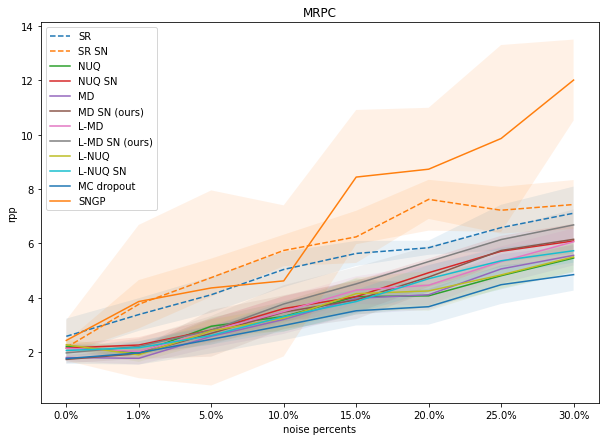

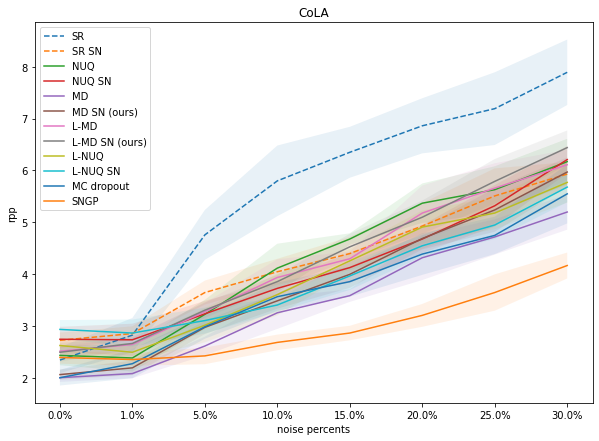

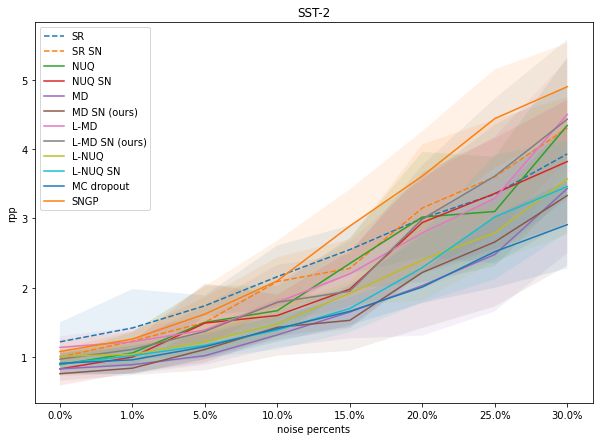

In [8]:
ue_algorithms = ['max_prob', 'nuq_total', 'mahalanobis_distance', 'ddu', 
                 'l_mahalanobis_distance', 'l_nuq_total', 'sampled_max_prob', 'std']

datasets = ['MRPC', 'CoLA', 'SST-2']
metric = 'rpp'
xvals = [0.0, 0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
table_res = pd.concat([table_all, baselines_all])

for dataset in datasets:
    plot_method_curves(table_res, ue_algorithms, dataset, metric, xvals, xname='noise_perc_')

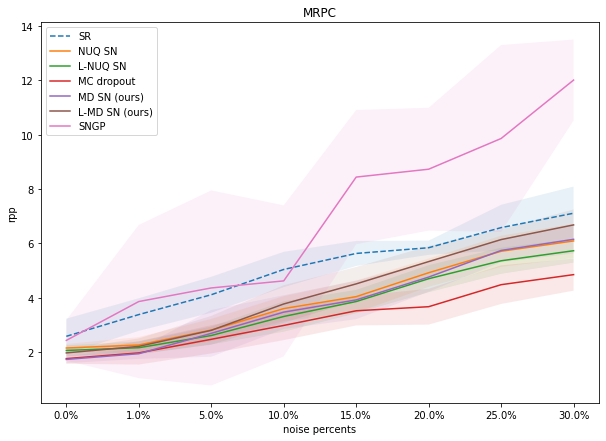

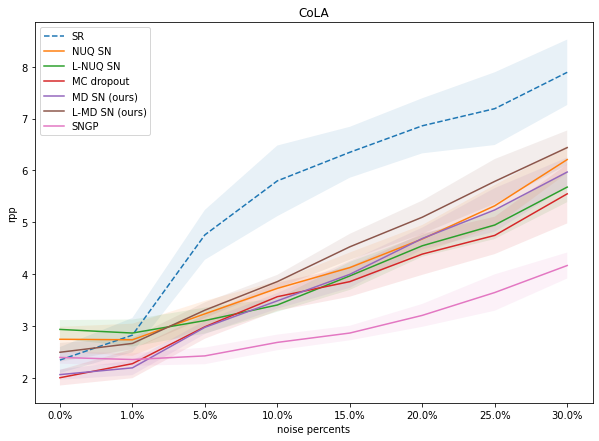

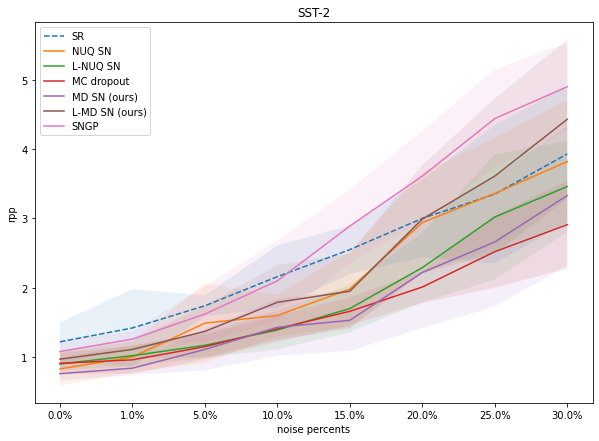

In [9]:
ue_algorithms = ['max_prob|no_sn', 'nuq_total|sn', 'l_nuq_total|sn', 'sampled_max_prob|no_sn',
                 'mahalanobis_distance|sn', 'l_mahalanobis_distance|sn', 'ddu|no_sn', 'std|sn']

datasets = ['MRPC', 'CoLA', 'SST-2']
metric = 'rpp'
xvals = [0.0, 0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
table_res = pd.concat([table_all, baselines_all])

save_dir = '../../workdir/curves'
for dataset in datasets:
    plot_method_curves(table_res, ue_algorithms, dataset, metric, xvals, xname='noise_perc_', save_dir=save_dir)

### subsample

In [10]:
metric_types = ["rcc-auc", 'rpp']
methods = ['l_mahalanobis', 'mahalanobis', 'nuq', 'l_nuq', 'mc', 'sngp']
regs = ['raw']
spectralnorm = ['sn', 'no_sn']
dataset_names = ['MRPC', 'CoLA', 'SST-2']
dataset_fnames = ['mrpc', 'cola', 'sst2']
subsample_perc1 = [0.001, 0.005, 0.01, 0.015, 0.02, 0.025, 0.03]
subsample_perc2 = [0.01, 0.02, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4]

subsample_percs = {
    'cola': subsample_perc2,
    'mrpc': subsample_perc2,
    'sst2': subsample_perc1,
}


names = []
tables_datasets = {}
for name, name_big in zip(dataset_fnames, dataset_names):
    tables = []
    baselines = []
    for method in methods:
        for reg in regs:
            for sn in spectralnorm:
                for subsample_perc in subsample_percs[name]:
                    if method == 'sngp' and sn != 'sn':
                        continue
                    run_dirs = []
                    names = [f'{method}|{reg}|{sn}|subsample_perc_{subsample_perc}']
                    if method == 'sngp':
                        model_series_dir = f'../../workdir/run_tasks_for_model_series/electra_{reg}_sngp/{name}/subsample_perc_{subsample_perc}/{method}'
                    else:
                        model_series_dir = f'../../workdir/run_tasks_for_model_series/electra_{reg}_{sn}/{name}/subsample_perc_{subsample_perc}/{method}'
                    run_dirs.append([model_series_dir])
                    agg_func = choose_agg_func(method)
                    try:
                        res_df = collect_datasets(run_dirs, names, [name_big], metric_types=metric_types, baselines={}, methods=agg_func)
                        baselines.append(res_df.iloc[-1:])
                        tables.append(res_df.iloc[:-1])
                        print(model_series_dir)
                    except:
                        print(f'pass {model_series_dir}')
                        pass
    table_dataset = pd.concat(tables).reset_index()
    baseline_dataset = pd.concat(baselines).reset_index()
    tables_datasets[name_big] = pd.concat([table_dataset.copy(), baseline_dataset.copy()])

../../workdir/run_tasks_for_model_series/electra_raw_sn/mrpc/subsample_perc_0.01/l_mahalanobis
../../workdir/run_tasks_for_model_series/electra_raw_sn/mrpc/subsample_perc_0.02/l_mahalanobis
../../workdir/run_tasks_for_model_series/electra_raw_sn/mrpc/subsample_perc_0.05/l_mahalanobis
../../workdir/run_tasks_for_model_series/electra_raw_sn/mrpc/subsample_perc_0.1/l_mahalanobis
../../workdir/run_tasks_for_model_series/electra_raw_sn/mrpc/subsample_perc_0.15/l_mahalanobis
../../workdir/run_tasks_for_model_series/electra_raw_sn/mrpc/subsample_perc_0.2/l_mahalanobis
../../workdir/run_tasks_for_model_series/electra_raw_sn/mrpc/subsample_perc_0.25/l_mahalanobis
../../workdir/run_tasks_for_model_series/electra_raw_sn/mrpc/subsample_perc_0.3/l_mahalanobis
../../workdir/run_tasks_for_model_series/electra_raw_sn/mrpc/subsample_perc_0.4/l_mahalanobis
../../workdir/run_tasks_for_model_series/electra_raw_no_sn/mrpc/subsample_perc_0.01/l_mahalanobis
../../workdir/run_tasks_for_model_series/electra_ra

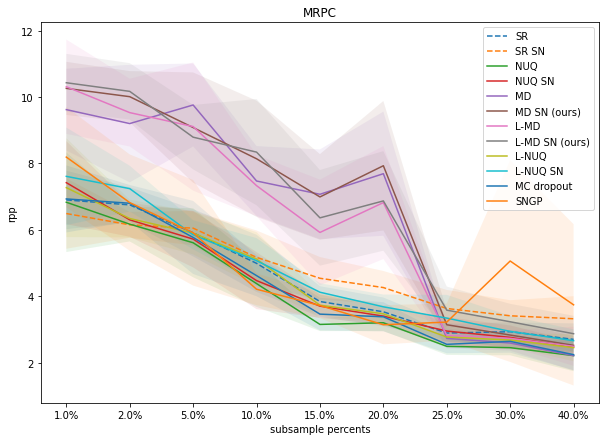

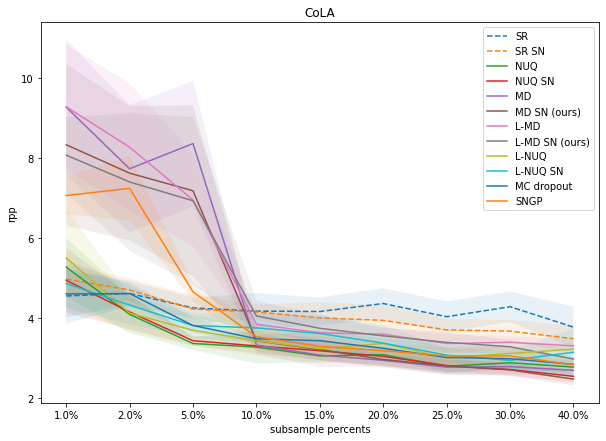

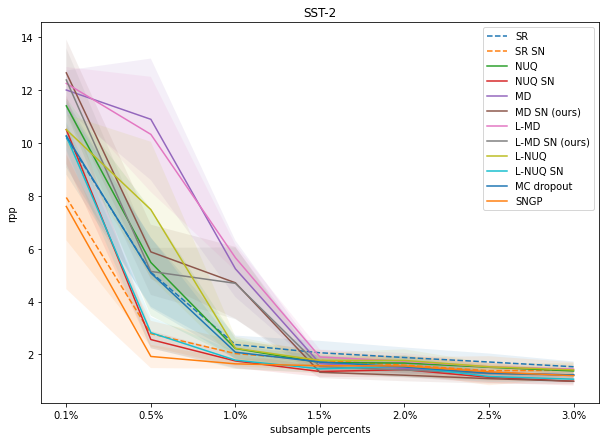

In [11]:
ue_algorithms = ['max_prob', 'nuq_aleatoric', 'mahalanobis_distance', 
                 'ddu', 'l_mahalanobis_distance', 'l_nuq_aleatoric', 'sampled_max_prob', 'std']

datasets = ['MRPC', 'CoLA', 'SST-2']
metric = 'rpp'
xvals = {
    'CoLA': subsample_perc2,
    'MRPC': subsample_perc2,
    'SST-2': subsample_perc1,
}


for dataset in datasets:
    plot_method_curves(tables_datasets[dataset], ue_algorithms, dataset, metric, xvals[dataset], xname='subsample_perc_')

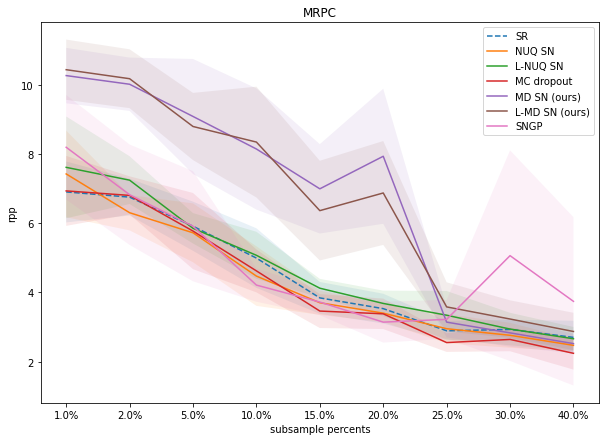

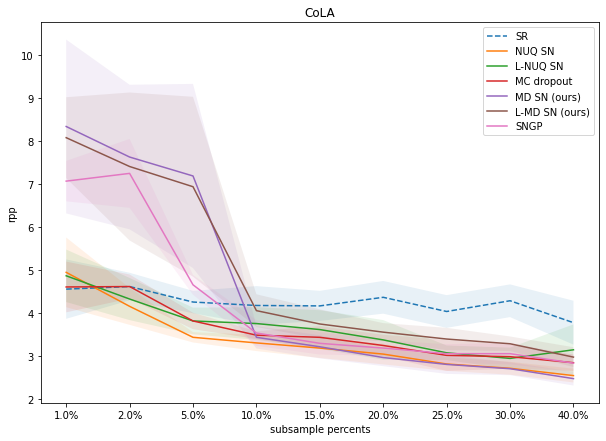

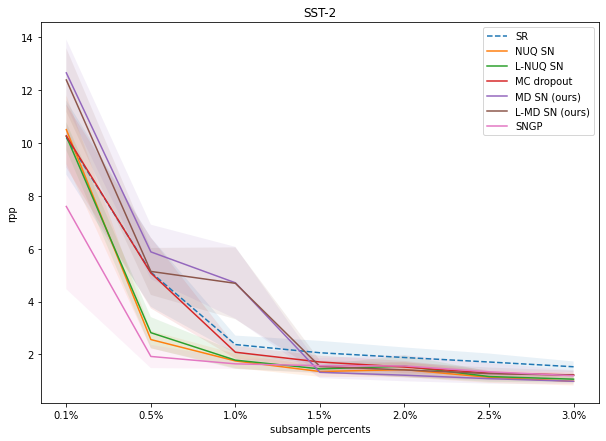

In [12]:
ue_algorithms = ['max_prob|no_sn', 'nuq_aleatoric|sn', 'l_nuq_aleatoric|sn', 'sampled_max_prob|no_sn',
                 'mahalanobis_distance|sn', 'l_mahalanobis_distance|sn', 'ddu|no_sn', 'std|sn']

datasets = ['MRPC', 'CoLA', 'SST-2']
metric = 'rpp'
xvals = {
    'CoLA': subsample_perc2,
    'MRPC': subsample_perc2,
    'SST-2': subsample_perc1,
}

save_dir = '../../workdir/curves'
for dataset in datasets:
    plot_method_curves(tables_datasets[dataset], ue_algorithms, dataset, metric, xvals[dataset], xname='subsample_perc_', save_dir=save_dir)

## OOD

In [6]:
import sys
sys.path.insert(0,'..')

import yaml
import os
from yaml import Loader as Loader
from pathlib import Path
import pandas as pd
import numpy as np
import json
import orjson as json
from sklearn.metrics import roc_auc_score

from analyze_results import (
    extract_result,
    aggregate_runs,
    from_model_outputs_calc_rcc_auc,
    format_results2,
    improvement_over_baseline,
    from_model_outputs_calc_pr_auc,
    from_model_outputs_calc_rpp,
    from_model_outputs_calc_roc_auc,
    from_model_outputs_calc_arc_auc,
    from_model_outputs_calc_f1_score
)

from utils.utils_wandb import init_wandb, wandb
from ue4nlp.ue_scores import *

In [7]:
def choose_metric(metric_type):
    if metric_type  == "rejection-curve-auc":
        return metric_type
    elif metric_type  == "roc-auc":
        return metric_type
    elif metric_type == "rcc-auc":
        return from_model_outputs_calc_rcc_auc
    elif metric_type == "rpp":
        return from_model_outputs_calc_rpp
    elif metric_type == "pr-auc":
        return from_model_outputs_calc_pr_auc
    elif metric_type == "f1-score":
        return from_model_outputs_calc_f1_score
    else:
        raise ValueError("Wrong metric type!")
        
def get_one_table(runs_dir, metric_types=["rejection-curve-auc", "roc-auc", "pr-auc"], baseline=None, methods=None):
    default_methods = {
        "bald": bald,
        "sampled_max_prob": sampled_max_prob,
        "variance": probability_variance,
    }
    
    if methods is None:
        methods = default_methods

    table = []
    for metric_type in metric_types:
        metric = choose_metric(metric_type=metric_type)

        agg_res = aggregate_runs(
            runs_dir, methods=methods, metric=metric, oos=True
        )
        if 'sngp' in runs_dir:
            x = agg_res.max_prob.values
            agg_res = agg_res[x > (x.mean() - x.std())]
            
        if agg_res.empty:
            print("Broken\n")
            continue

        if metric_type == "rcc-auc":
            final_score = format_results2(agg_res, percents=False)
        elif metric_type == "rpp":
            final_score = format_results2(agg_res, percents=True)
        elif metric_type == "accuracy":
            final_score = format_results2(agg_res, percents=True)
        else:
            final_score = improvement_over_baseline(agg_res, baseline_col="max_prob", baseline=baseline, metric=metric_type, percents=True, subtract=False)
        table.append(final_score)
    res_table = pd.concat(table, axis=1)
    res_table.columns = metric_types
    # fix for rcc-auc and rpp
    if 'baseline (max_prob)' not in res_table.index:
        res_table.loc['baseline (max_prob)'] = 0
    try:
        res_table = res_table.drop(['max_prob', 'count'])
    except:
        res_table = res_table.drop(['count'])
    return res_table


def collect_tables(run_dirs, names, metric_types=["rejection-curve-auc", "roc-auc", "rcc-auc", "pr-auc", "rpp"], baseline=None, methods=None):
    all_tables = []
    for run_dir, name in zip(run_dirs, names):
        buf_table = get_one_table(run_dir, metric_types, baseline, methods)
        #print(buf_table)
        # add name to index
        indices = [(name, ind) for ind in list(buf_table.index)]
        baseline_name = 'baseline|'+'|'.join(name.split('|')[1:])
        buf_table.loc[baseline_name] = buf_table.loc['baseline (max_prob)']
        # add reindex
        indices = indices + [(baseline_name, 'max_prob')]
        
        index = pd.MultiIndex.from_tuples(indices, names=['Method', 'UE Score'])
        buf_table.index = index
        buf_table.drop((name, 'baseline (max_prob)'), inplace=True)
        # add buf_table to final_table
        all_tables.append(buf_table)
    return pd.concat(all_tables)


def collect_datasets(runs_dirs, names, dataset_names, metric_types=["rejection-curve-auc", "roc-auc", "rcc-auc", "pr-auc", "rpp"], baselines={}, methods=None):
    all_tables = []
    for run_dir, dataset_name in zip(runs_dirs, dataset_names):
        #try:
        dataset_table = collect_tables(run_dir, names, metric_types, baselines.get(dataset_name, None), methods=methods)
        columns = pd.MultiIndex.from_tuples([(dataset_name, ind) for ind in list(dataset_table.columns)])
        dataset_table.columns = columns
        all_tables.append(dataset_table)
        #except:
        #    print(f'empty dir {run_dir}')
    return pd.concat(all_tables, axis=1)

### noise

In [8]:
metric_types=["roc-auc"]
methods = ['l_mahalanobis', 'mahalanobis', 'nuq', 'l_nuq', 'mc', 'sngp']
regs = ['raw']
spectralnorm = ['sn', 'no_sn']
dataset_names = ['CLINC', 'ROSTD']
dataset_fnames = ['clinc', 'rostd']
noise_percs = [0.0, 0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]

names = []
tables = []
baselines = []
for method in methods:
    for reg in regs:
        for sn in spectralnorm:
            for noise_perc in noise_percs:
                if method == 'sngp' and sn != 'sn':
                    continue
                run_dirs = []
                names = [f'{method}|{reg}|{sn}|noise_perc_{noise_perc}']
                if noise_perc == 0:
                    path_name = 'subsample_perc_'
                else:
                    path_name = 'noise_perc_'
                for name in dataset_fnames:
                    if method == 'sngp':
                        model_series_dir = f'../../workdir/run_tasks_for_model_series/electra_{reg}_sngp/{name}/{path_name}{noise_perc}/{method}'
                    else:
                        model_series_dir = f'../../workdir/run_tasks_for_model_series/electra_{reg}_{sn}/{name}/{path_name}{noise_perc}/{method}'
                    run_dirs.append([model_series_dir])
                agg_func = choose_agg_func(method)
                try:
                    res_df = collect_datasets(run_dirs, names, dataset_names, metric_types=metric_types, baselines={}, methods=agg_func)
                    baselines.append(res_df.iloc[-1:])
                    tables.append(res_df.iloc[:-1])
                    print(model_series_dir)
                except:
                    print(f'pass {model_series_dir}')
                    pass

../../workdir/run_tasks_for_model_series/electra_raw_sn/rostd/subsample_perc_0.0/l_mahalanobis
../../workdir/run_tasks_for_model_series/electra_raw_sn/rostd/noise_perc_0.01/l_mahalanobis
../../workdir/run_tasks_for_model_series/electra_raw_sn/rostd/noise_perc_0.05/l_mahalanobis
../../workdir/run_tasks_for_model_series/electra_raw_sn/rostd/noise_perc_0.1/l_mahalanobis
../../workdir/run_tasks_for_model_series/electra_raw_sn/rostd/noise_perc_0.15/l_mahalanobis
../../workdir/run_tasks_for_model_series/electra_raw_sn/rostd/noise_perc_0.2/l_mahalanobis
../../workdir/run_tasks_for_model_series/electra_raw_sn/rostd/noise_perc_0.25/l_mahalanobis
../../workdir/run_tasks_for_model_series/electra_raw_sn/rostd/noise_perc_0.3/l_mahalanobis
../../workdir/run_tasks_for_model_series/electra_raw_no_sn/rostd/subsample_perc_0.0/l_mahalanobis
../../workdir/run_tasks_for_model_series/electra_raw_no_sn/rostd/noise_perc_0.01/l_mahalanobis
../../workdir/run_tasks_for_model_series/electra_raw_no_sn/rostd/noise_

In [9]:
baselines_all = pd.concat([pd.concat(baselines)]).reset_index()
table_all = pd.concat([pd.concat(tables)]).reset_index()

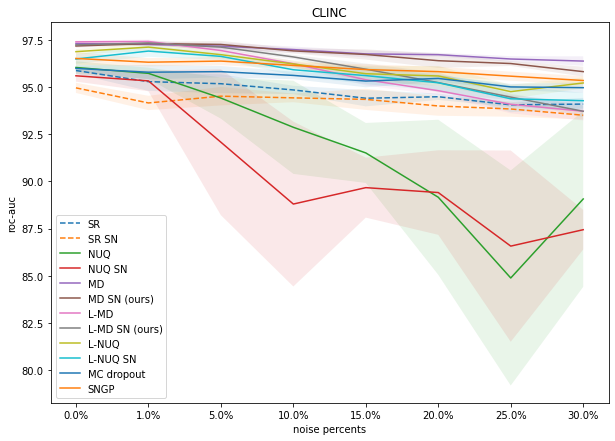

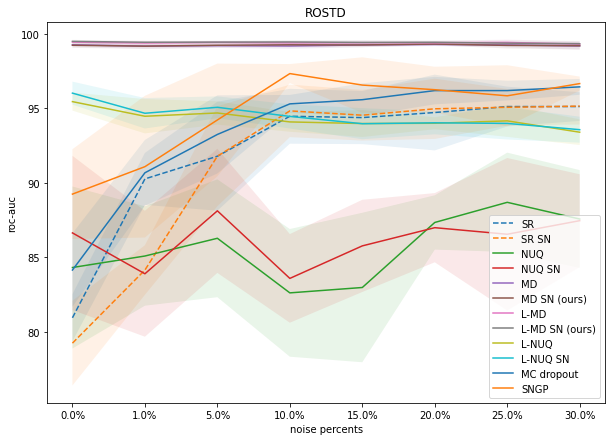

In [10]:
ue_algorithms = ['max_prob', 'nuq_epistemic', 'mahalanobis_distance', 'ddu', 
                 'l_mahalanobis_distance', 'l_nuq_epistemic', 'sampled_max_prob', 'std']

datasets = ['CLINC', 'ROSTD']
metric = 'roc-auc'
xvals = [0.0, 0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
table_res = pd.concat([table_all, baselines_all])

for dataset in datasets:
    plot_method_curves(table_res, ue_algorithms, dataset, metric, xvals, xname='noise_perc_')

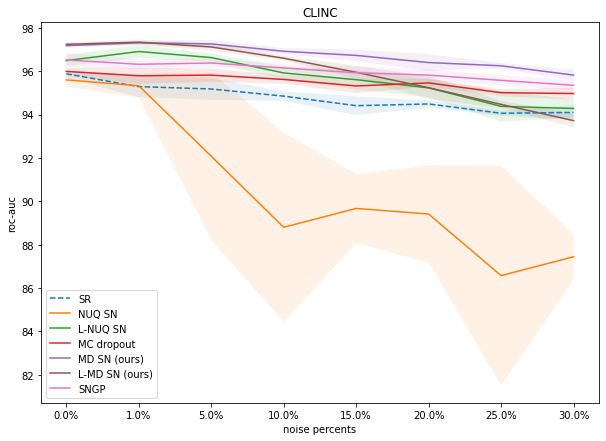

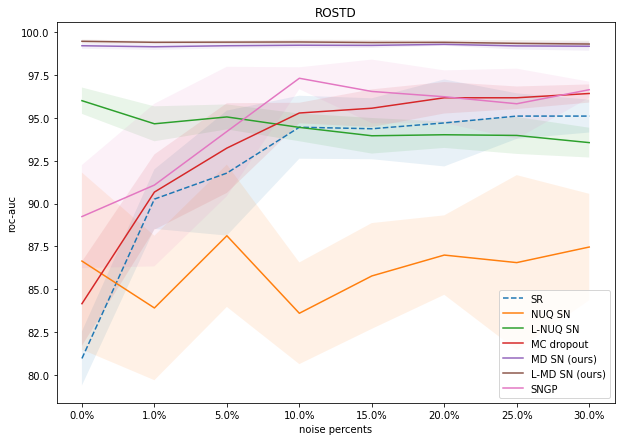

In [11]:
ue_algorithms = ['max_prob|no_sn', 'nuq_epistemic|sn', 'l_nuq_epistemic|sn', 'sampled_max_prob|no_sn',
                 'mahalanobis_distance|sn', 'l_mahalanobis_distance|sn', 'ddu|sn', 'std|sn']

datasets = ['CLINC', 'ROSTD']
metric = 'roc-auc'
xvals = [0.0, 0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
table_res = pd.concat([table_all, baselines_all])

save_dir = '../../workdir/curves'
for dataset in datasets:
    plot_method_curves(table_res, ue_algorithms, dataset, metric, xvals, xname='noise_perc_', save_dir=save_dir)

### subsample

In [19]:
metric_types = ["roc-auc"]
methods = ['l_mahalanobis', 'mahalanobis', 'nuq', 'l_nuq', 'mc', 'sngp']
regs = ['raw']
spectralnorm = ['sn', 'no_sn']
dataset_names = ['CLINC', 'ROSTD']
dataset_fnames = ['clinc', 'rostd']
subsample_perc1 = [0.0, 0.01, 0.02, 0.05, 0.1, 0.15, 0.2]
subsample_perc2 = [0.0, 0.005, 0.01, 0.015, 0.02, 0.03, 0.04]

subsample_percs = {
    'rostd': subsample_perc2,
    'clinc': subsample_perc1,
}


names = []
tables_datasets = {}
for name, name_big in zip(dataset_fnames, dataset_names):
    tables = []
    baselines = []
    for method in methods:
        for reg in regs:
            for sn in spectralnorm:
                for subsample_perc in subsample_percs[name]:
                    if method == 'sngp' and sn != 'sn':
                        continue
                    run_dirs = []
                    names = [f'{method}|{reg}|{sn}|subsample_perc_{subsample_perc}']
                    if method == 'sngp':
                        model_series_dir = f'../../workdir/run_tasks_for_model_series/electra_{reg}_sngp/{name}/subsample_perc_{subsample_perc}/{method}'
                    else:
                        model_series_dir = f'../../workdir/run_tasks_for_model_series/electra_{reg}_{sn}/{name}/subsample_perc_{subsample_perc}/{method}'
                    run_dirs.append([model_series_dir])
                    agg_func = choose_agg_func(method)
                    try:
                        res_df = collect_datasets(run_dirs, names, [name_big], metric_types=metric_types, baselines={}, methods=agg_func)
                        baselines.append(res_df.iloc[-1:])
                        tables.append(res_df.iloc[:-1])
                        print(model_series_dir)
                    except:
                        print(f'pass {model_series_dir}')
                        pass
    table_dataset = pd.concat(tables).reset_index()
    baseline_dataset = pd.concat(baselines).reset_index()
    tables_datasets[name_big] = pd.concat([table_dataset.copy(), baseline_dataset.copy()])

../../workdir/run_tasks_for_model_series/electra_raw_sn/clinc/subsample_perc_0.0/l_mahalanobis
../../workdir/run_tasks_for_model_series/electra_raw_sn/clinc/subsample_perc_0.01/l_mahalanobis
../../workdir/run_tasks_for_model_series/electra_raw_sn/clinc/subsample_perc_0.02/l_mahalanobis
../../workdir/run_tasks_for_model_series/electra_raw_sn/clinc/subsample_perc_0.05/l_mahalanobis
../../workdir/run_tasks_for_model_series/electra_raw_sn/clinc/subsample_perc_0.1/l_mahalanobis
../../workdir/run_tasks_for_model_series/electra_raw_sn/clinc/subsample_perc_0.15/l_mahalanobis
../../workdir/run_tasks_for_model_series/electra_raw_sn/clinc/subsample_perc_0.2/l_mahalanobis
../../workdir/run_tasks_for_model_series/electra_raw_no_sn/clinc/subsample_perc_0.0/l_mahalanobis
../../workdir/run_tasks_for_model_series/electra_raw_no_sn/clinc/subsample_perc_0.01/l_mahalanobis
../../workdir/run_tasks_for_model_series/electra_raw_no_sn/clinc/subsample_perc_0.02/l_mahalanobis
../../workdir/run_tasks_for_model_s

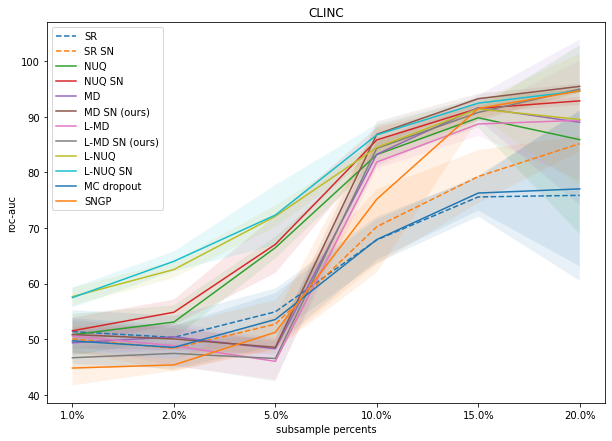

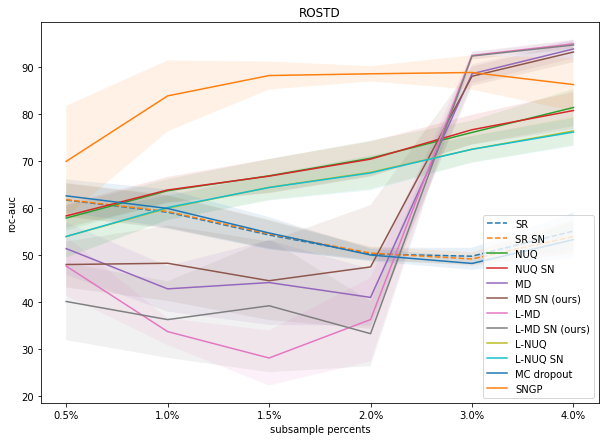

In [20]:
ue_algorithms = ['max_prob', 'nuq_epistemic', 'mahalanobis_distance', 'ddu', 
                 'l_mahalanobis_distance', 'l_nuq_epistemic', 'sampled_max_prob', 'std']

datasets = ['CLINC', 'ROSTD']
metric = 'roc-auc'
subsample_perc1 = [0.01, 0.02, 0.05, 0.1, 0.15, 0.2]
subsample_perc2 = [0.005, 0.01, 0.015, 0.02, 0.03, 0.04]

xvals = {
    'ROSTD': subsample_perc2,
    'CLINC': subsample_perc1,
}

for dataset in datasets:
    plot_method_curves(tables_datasets[dataset], ue_algorithms, dataset, metric, xvals[dataset], xname='subsample_perc_')

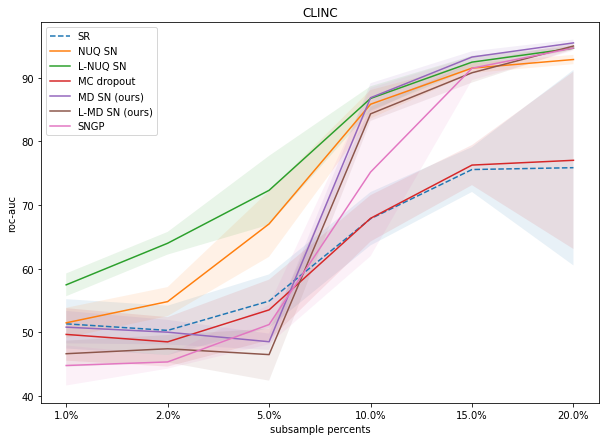

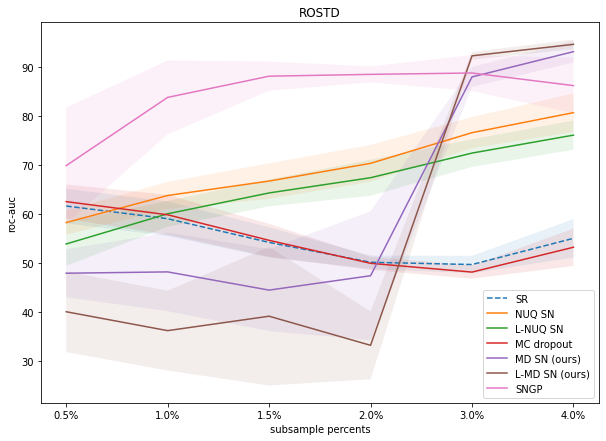

In [21]:
ue_algorithms = ['max_prob|no_sn', 'nuq_epistemic|sn', 'l_nuq_epistemic|sn', 'sampled_max_prob|no_sn',
                 'mahalanobis_distance|sn', 'l_mahalanobis_distance|sn', 'ddu|sn', 'std|sn']

datasets = ['CLINC', 'ROSTD']
metric = 'roc-auc'
subsample_perc1 = [0.01, 0.02, 0.05, 0.1, 0.15, 0.2]
subsample_perc2 = [0.005, 0.01, 0.015, 0.02, 0.03, 0.04]

xvals = {
    'ROSTD': subsample_perc2,
    'CLINC': subsample_perc1,
}

save_dir = '../../workdir/curves'
for dataset in datasets:
    plot_method_curves(tables_datasets[dataset], ue_algorithms, dataset, metric, xvals[dataset], xname='subsample_perc_', save_dir=save_dir)

## OOD new benchmark

### subsample (SST-2)

In [12]:
metric_types=["roc-auc"]

methods = ['l_mahalanobis', 'mahalanobis', 'nuq', 'l_nuq', 'mc', 'sngp']
regs = ['raw']
spectralnorm = ['no_sn', 'sn']
dataset_names = ['IMDB', 'TREC', 'WMT16', 'Amazon', 'MNLI', '20newsgroups', 'RTE']
dataset_fnames = ['imdb', 'trec', 'wmt16', 'amazon', 'mnli', '20newsgroups', 'rte']
subsample_percs = [0.001, 0.005, 0.01, 0.015, 0.02, 0.03]
names = []
tables = []
baselines = []
for method in methods:
    for reg in regs:
        for sn in spectralnorm:
            for subsample_perc in subsample_percs:
                if method == 'sngp' and sn != 'sn':
                    continue
                run_dirs = []
                name_sn = ''
                names = [f'{method}|{reg}|{sn}|subsample_perc_{subsample_perc}']
                for name in dataset_fnames:
                    if method == 'sngp':
                        model_series_dir = f'../../workdir/run_tasks_for_model_series/electra_{reg}_sngp/sst2/subsample_perc_{subsample_perc}/{name}/{method}'
                    else:
                        model_series_dir = f'../../workdir/run_tasks_for_model_series/electra_{reg}_{sn}/sst2/subsample_perc_{subsample_perc}/{name}/{method}'
                    print(model_series_dir)
                    run_dirs.append([model_series_dir])
                agg_func = choose_agg_func(method)
                try:
                    res_df = collect_datasets(run_dirs, names, dataset_names, metric_types=metric_types, baselines={}, methods=agg_func)
                    baselines.append(res_df.iloc[-1:])
                    tables.append(res_df.iloc[:-1])
                except:
                    print('pass')
                    pass

../../workdir/run_tasks_for_model_series/electra_raw_no_sn/sst2/subsample_perc_0.001/imdb/l_mahalanobis
../../workdir/run_tasks_for_model_series/electra_raw_no_sn/sst2/subsample_perc_0.001/trec/l_mahalanobis
../../workdir/run_tasks_for_model_series/electra_raw_no_sn/sst2/subsample_perc_0.001/wmt16/l_mahalanobis
../../workdir/run_tasks_for_model_series/electra_raw_no_sn/sst2/subsample_perc_0.001/amazon/l_mahalanobis
../../workdir/run_tasks_for_model_series/electra_raw_no_sn/sst2/subsample_perc_0.001/mnli/l_mahalanobis
../../workdir/run_tasks_for_model_series/electra_raw_no_sn/sst2/subsample_perc_0.001/20newsgroups/l_mahalanobis
../../workdir/run_tasks_for_model_series/electra_raw_no_sn/sst2/subsample_perc_0.001/rte/l_mahalanobis
pass
../../workdir/run_tasks_for_model_series/electra_raw_no_sn/sst2/subsample_perc_0.005/imdb/l_mahalanobis
../../workdir/run_tasks_for_model_series/electra_raw_no_sn/sst2/subsample_perc_0.005/trec/l_mahalanobis
../../workdir/run_tasks_for_model_series/electra_

In [13]:
baselines_all = pd.concat([pd.concat(baselines)]).reset_index()
table_all = pd.concat([pd.concat(tables)]).reset_index()

roc_auc_mean = table_all[table_all.columns[2:]].apply(lambda x: x.str.split('±').str[0].astype(float)).mean(axis=1)
roc_auc_std = table_all[table_all.columns[2:]].apply(lambda x: x.str.split('±').str[1].astype(float)).mean(axis=1)

table_all[('SST-2 (Mean)',  'roc-auc')] = roc_auc_mean.round(2).astype(str)+'±'+roc_auc_std.round(2).astype(str)


roc_auc_mean = baselines_all[baselines_all.columns[2:]].apply(lambda x: x.str.split('±').str[0].astype(float)).mean(axis=1)
roc_auc_std = baselines_all[baselines_all.columns[2:]].apply(lambda x: x.str.split('±').str[1].astype(float)).mean(axis=1)

baselines_all[('SST-2 (Mean)',  'roc-auc')] = roc_auc_mean.round(2).astype(str)+'±'+roc_auc_std.round(2).astype(str)

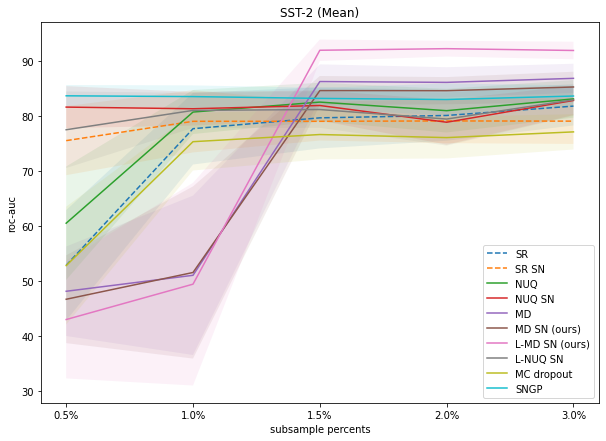

In [14]:
ue_algorithms = ['max_prob', 'nuq_epistemic', 'mahalanobis_distance', 'ddu', 
                 'l_mahalanobis_distance', 'l_nuq_epistemic', 'sampled_max_prob', 'std']

datasets = ['SST-2 (Mean)']
metric = 'roc-auc'
xvals = [0.005, 0.01, 0.015, 0.02, 0.03, 0.04, 0.05]

table_res = pd.concat([table_all, baselines_all])

for dataset in datasets:
    plot_method_curves(table_res, ue_algorithms, dataset, metric, xvals, xname='subsample_perc_')

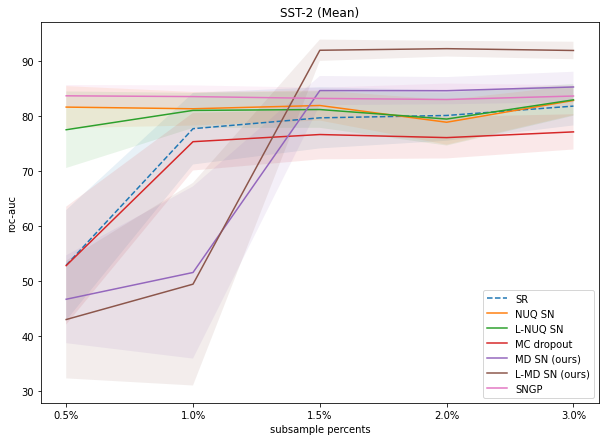

In [15]:
ue_algorithms = ['max_prob|no_sn', 'nuq_epistemic|sn', 'l_nuq_epistemic|sn', 'sampled_max_prob|no_sn',
                 'mahalanobis_distance|sn', 'l_mahalanobis_distance|sn', 'ddu|sn', 'std|sn']


datasets = ['SST-2 (Mean)']
metric = 'roc-auc'
xvals = [0.005, 0.01, 0.015, 0.02, 0.03, 0.04, 0.05]

table_res = pd.concat([table_all, baselines_all])

save_dir = '../../workdir/curves'
for dataset in datasets:
    plot_method_curves(table_res, ue_algorithms, dataset, metric, xvals, xname='subsample_perc_', save_dir=save_dir)

### subsample (20newsgroups)

In [8]:
metric_types=["roc-auc"]

methods = ['l_mahalanobis', 'mahalanobis', 'ddu', 'nuq', 'l_nuq', 'mc', 'sngp']
regs = ['raw']
spectralnorm = ['no_sn', 'sn']
dataset_names = ['IMDB', 'TREC', 'WMT16', 'Amazon', 'MNLI', 'SST-2', 'RTE']
dataset_fnames = ['imdb', 'trec', 'wmt16', 'amazon', 'mnli', 'sst2', 'rte']
subsample_percs = [0.001, 0.005, 0.01, 0.015, 0.02, 0.03]
names = []
tables = []
baselines = []
for method in methods:
    for reg in regs:
        for sn in spectralnorm:
            for subsample_perc in subsample_percs:
                if method == 'sngp' and sn != 'sn':
                    continue
                run_dirs = []
                name_sn = ''
                names = [f'{method}|{reg}|{sn}|subsample_perc_{subsample_perc}']
                for name in dataset_fnames:
                    if method == 'sngp':
                        model_series_dir = f'../../workdir/run_tasks_for_model_series/electra_{reg}_sngp/20newsgroups/subsample_perc_{subsample_perc}/{name}/{method}'
                    else:
                        model_series_dir = f'../../workdir/run_tasks_for_model_series/electra_{reg}_{sn}/20newsgroups/subsample_perc_{subsample_perc}/{name}/{method}'
                    print(model_series_dir)
                    run_dirs.append([model_series_dir])
                agg_func = choose_agg_func(method)
                try:
                    res_df = collect_datasets(run_dirs, names, dataset_names, metric_types=metric_types, baselines={}, methods=agg_func)
                    baselines.append(res_df.iloc[-1:])
                    tables.append(res_df.iloc[:-1])
                except:
                    print('pass')
                    pass

../../workdir/run_tasks_for_model_series/electra_raw_no_sn/20newsgroups/subsample_perc_0.001/imdb/l_mahalanobis
../../workdir/run_tasks_for_model_series/electra_raw_no_sn/20newsgroups/subsample_perc_0.001/trec/l_mahalanobis
../../workdir/run_tasks_for_model_series/electra_raw_no_sn/20newsgroups/subsample_perc_0.001/wmt16/l_mahalanobis
../../workdir/run_tasks_for_model_series/electra_raw_no_sn/20newsgroups/subsample_perc_0.001/amazon/l_mahalanobis
../../workdir/run_tasks_for_model_series/electra_raw_no_sn/20newsgroups/subsample_perc_0.001/mnli/l_mahalanobis
../../workdir/run_tasks_for_model_series/electra_raw_no_sn/20newsgroups/subsample_perc_0.001/sst2/l_mahalanobis
../../workdir/run_tasks_for_model_series/electra_raw_no_sn/20newsgroups/subsample_perc_0.001/rte/l_mahalanobis
pass
../../workdir/run_tasks_for_model_series/electra_raw_no_sn/20newsgroups/subsample_perc_0.005/imdb/l_mahalanobis
../../workdir/run_tasks_for_model_series/electra_raw_no_sn/20newsgroups/subsample_perc_0.005/trec

In [9]:
baselines_all = pd.concat([pd.concat(baselines)]).reset_index()
table_all = pd.concat([pd.concat(tables)]).reset_index()

roc_auc_mean = table_all[table_all.columns[2:]].apply(lambda x: x.str.split('±').str[0].astype(float)).mean(axis=1)
roc_auc_std = table_all[table_all.columns[2:]].apply(lambda x: x.str.split('±').str[1].astype(float)).mean(axis=1)

table_all[('20newsgroups (Mean)',  'roc-auc')] = roc_auc_mean.round(2).astype(str)+'±'+roc_auc_std.round(2).astype(str)


roc_auc_mean = baselines_all[baselines_all.columns[2:]].apply(lambda x: x.str.split('±').str[0].astype(float)).mean(axis=1)
roc_auc_std = baselines_all[baselines_all.columns[2:]].apply(lambda x: x.str.split('±').str[1].astype(float)).mean(axis=1)

baselines_all[('20newsgroups (Mean)',  'roc-auc')] = roc_auc_mean.round(2).astype(str)+'±'+roc_auc_std.round(2).astype(str)

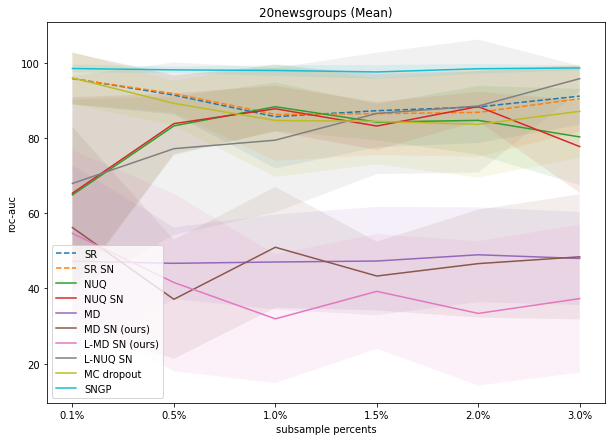

In [10]:
ue_algorithms = ['max_prob', 'nuq_epistemic', 'mahalanobis_distance', 
                 'l_mahalanobis_distance', 'l_nuq_epistemic', 'sampled_max_prob', 'std']

datasets = ['20newsgroups (Mean)']
metric = 'roc-auc'
xvals = [0.001, 0.005, 0.01, 0.015, 0.02, 0.03]

table_res = pd.concat([table_all, baselines_all])

for dataset in datasets:
    plot_method_curves(table_res, ue_algorithms, dataset, metric, xvals, xname='subsample_perc_')

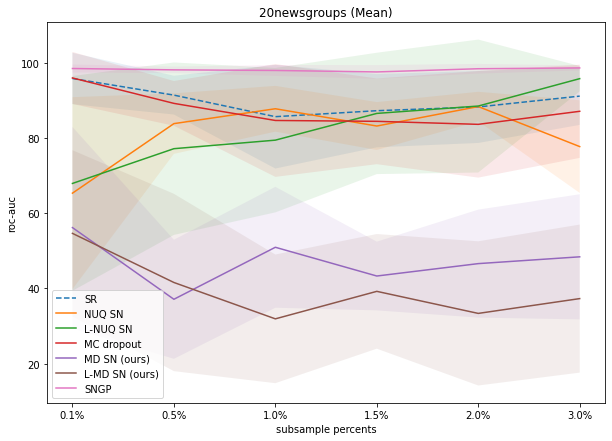

In [11]:
ue_algorithms = ['max_prob|no_sn', 'nuq_epistemic|sn', 'l_nuq_epistemic|sn', 'sampled_max_prob|no_sn',
                 'mahalanobis_distance|sn', 'l_mahalanobis_distance|sn','std|sn']
datasets = ['20newsgroups (Mean)']
metric = 'roc-auc'
xvals = [0.001, 0.005, 0.01, 0.015, 0.02, 0.03]

table_res = pd.concat([table_all, baselines_all])
save_dir = '../../workdir/curves'

for dataset in datasets:
    plot_method_curves(table_res, ue_algorithms, dataset, metric, xvals, xname='subsample_perc_', save_dir=save_dir)

### Noise

In [12]:
metric_types=["roc-auc"]

methods = ['l_mahalanobis', 'mahalanobis', 'nuq', 'l_nuq', 'mc', 'sngp']
regs = ['raw']
spectralnorm = ['no_sn', 'sn']
dataset_names = ['IMDB', 'TREC', 'WMT16', 'Amazon', 'MNLI', '20newsgroups', 'RTE']
dataset_fnames = ['imdb', 'trec', 'wmt16', 'amazon', 'mnli', '20newsgroups', 'rte']
noise_percs = [0.0, 0.01, 0.05, 0.1, 0.15, 0.2, 0.3]
names = []
tables = []
baselines = []
for method in methods:
    for reg in regs:
        for sn in spectralnorm:
            for noise_perc in noise_percs:
                if noise_perc == 0:
                    path_name = 'subsample_perc_'
                    real_noise = 0.1
                else:
                    path_name = 'noise_perc_'
                    real_noise = noise_perc
                if method == 'sngp' and sn != 'sn':
                    continue
                run_dirs = []
                name_sn = ''
                names = [f'{method}|{reg}|{sn}|noise_perc_{noise_perc}']
                for name in dataset_fnames:
                    if method == 'sngp':
                        model_series_dir = f'../../workdir/run_tasks_for_model_series/electra_{reg}_sngp/sst2/{path_name}{real_noise}/{name}/{method}'
                    else:
                        model_series_dir = f'../../workdir/run_tasks_for_model_series/electra_{reg}_{sn}/sst2/{path_name}{real_noise}/{name}/{method}'
                    print(model_series_dir)
                    run_dirs.append([model_series_dir])
                agg_func = choose_agg_func(method)
                try:
                    res_df = collect_datasets(run_dirs, names, dataset_names, metric_types=metric_types, baselines={}, methods=agg_func)
                    baselines.append(res_df.iloc[-1:])
                    tables.append(res_df.iloc[:-1])
                except:
                    print('pass')
                    pass

../../workdir/run_tasks_for_model_series/electra_raw_no_sn/sst2/subsample_perc_0.1/imdb/l_mahalanobis
../../workdir/run_tasks_for_model_series/electra_raw_no_sn/sst2/subsample_perc_0.1/trec/l_mahalanobis
../../workdir/run_tasks_for_model_series/electra_raw_no_sn/sst2/subsample_perc_0.1/wmt16/l_mahalanobis
../../workdir/run_tasks_for_model_series/electra_raw_no_sn/sst2/subsample_perc_0.1/amazon/l_mahalanobis
../../workdir/run_tasks_for_model_series/electra_raw_no_sn/sst2/subsample_perc_0.1/mnli/l_mahalanobis
../../workdir/run_tasks_for_model_series/electra_raw_no_sn/sst2/subsample_perc_0.1/20newsgroups/l_mahalanobis
../../workdir/run_tasks_for_model_series/electra_raw_no_sn/sst2/subsample_perc_0.1/rte/l_mahalanobis
pass
../../workdir/run_tasks_for_model_series/electra_raw_no_sn/sst2/noise_perc_0.01/imdb/l_mahalanobis
../../workdir/run_tasks_for_model_series/electra_raw_no_sn/sst2/noise_perc_0.01/trec/l_mahalanobis
../../workdir/run_tasks_for_model_series/electra_raw_no_sn/sst2/noise_per

In [13]:
baselines_all = pd.concat([pd.concat(baselines)]).reset_index()
table_all = pd.concat([pd.concat(tables)]).reset_index()

roc_auc_mean = table_all[table_all.columns[2:]].apply(lambda x: x.str.split('±').str[0].astype(float)).mean(axis=1)
roc_auc_std = table_all[table_all.columns[2:]].apply(lambda x: x.str.split('±').str[1].astype(float)).mean(axis=1)

table_all[('SST-2 (Mean)',  'roc-auc')] = roc_auc_mean.round(2).astype(str)+'±'+roc_auc_std.round(2).astype(str)


roc_auc_mean = baselines_all[baselines_all.columns[2:]].apply(lambda x: x.str.split('±').str[0].astype(float)).mean(axis=1)
roc_auc_std = baselines_all[baselines_all.columns[2:]].apply(lambda x: x.str.split('±').str[1].astype(float)).mean(axis=1)

baselines_all[('SST-2 (Mean)',  'roc-auc')] = roc_auc_mean.round(2).astype(str)+'±'+roc_auc_std.round(2).astype(str)

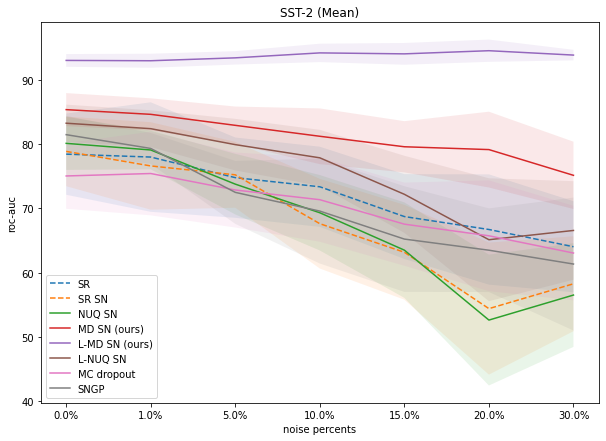

In [14]:
ue_algorithms = ['max_prob', 'nuq_epistemic', 'mahalanobis_distance', 'ddu', 
                 'l_mahalanobis_distance', 'l_nuq_epistemic', 'sampled_max_prob', 'std']

datasets = ['SST-2 (Mean)']
metric = 'roc-auc'
xvals = [0.0, 0.01, 0.05, 0.1, 0.15, 0.2, 0.3]

table_res = pd.concat([table_all, baselines_all])

for dataset in datasets:
    plot_method_curves(table_res, ue_algorithms, dataset, metric, xvals, xname='noise_perc_')

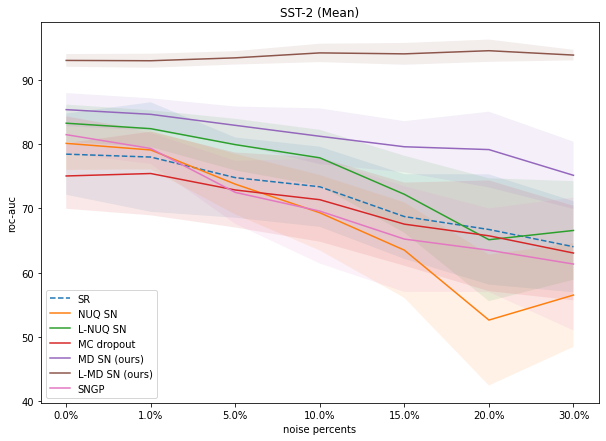

In [15]:
ue_algorithms = ['max_prob|no_sn', 'nuq_epistemic|sn', 'l_nuq_epistemic|sn', 'sampled_max_prob|no_sn',
                 'mahalanobis_distance|sn', 'l_mahalanobis_distance|sn', 'ddu|sn', 'std|sn']


datasets = ['SST-2 (Mean)']
metric = 'roc-auc'
xvals = [0.0, 0.01, 0.05, 0.1, 0.15, 0.2, 0.3]

table_res = pd.concat([table_all, baselines_all])

save_dir = '../../workdir/curves'
for dataset in datasets:
    plot_method_curves(table_res, ue_algorithms, dataset, metric, xvals, xname='noise_perc_', save_dir=save_dir)

### Noise (20NG)

In [16]:
metric_types=["roc-auc"]

methods = ['l_mahalanobis', 'mahalanobis', 'ddu', 'nuq', 'l_nuq', 'mc', 'sngp']
regs = ['raw']
spectralnorm = ['no_sn', 'sn']
dataset_names = ['IMDB', 'TREC', 'WMT16', 'Amazon', 'MNLI', 'SST-2', 'RTE']
dataset_fnames = ['imdb', 'trec', 'wmt16', 'amazon', 'mnli', 'sst2', 'rte']
noise_percs = [0.0, 0.01, 0.05, 0.1, 0.15, 0.2, 0.3]
names = []
tables = []
baselines = []
for method in methods:
    for reg in regs:
        for sn in spectralnorm:
            for noise_perc in noise_percs:
                if noise_perc == 0:
                    path_name = 'subsample_perc_'
                else:
                    path_name = 'noise_perc_'
                if method == 'sngp' and sn != 'sn':
                    continue
                run_dirs = []
                name_sn = ''
                names = [f'{method}|{reg}|{sn}|noise_perc_{noise_perc}']
                for name in dataset_fnames:
                    if method == 'sngp':
                        model_series_dir = f'../../workdir/run_tasks_for_model_series/electra_{reg}_sngp/20newsgroups/{path_name}{noise_perc}/{name}/{method}'
                    else:
                        model_series_dir = f'../../workdir/run_tasks_for_model_series/electra_{reg}_{sn}/20newsgroups/{path_name}{noise_perc}/{name}/{method}'
                    print(model_series_dir)
                    run_dirs.append([model_series_dir])
                agg_func = choose_agg_func(method)
                try:
                    res_df = collect_datasets(run_dirs, names, dataset_names, metric_types=metric_types, baselines={}, methods=agg_func)
                    baselines.append(res_df.iloc[-1:])
                    tables.append(res_df.iloc[:-1])
                except:
                    print('pass')
                    pass

../../workdir/run_tasks_for_model_series/electra_raw_no_sn/20newsgroups/subsample_perc_0.0/imdb/l_mahalanobis
../../workdir/run_tasks_for_model_series/electra_raw_no_sn/20newsgroups/subsample_perc_0.0/trec/l_mahalanobis
../../workdir/run_tasks_for_model_series/electra_raw_no_sn/20newsgroups/subsample_perc_0.0/wmt16/l_mahalanobis
../../workdir/run_tasks_for_model_series/electra_raw_no_sn/20newsgroups/subsample_perc_0.0/amazon/l_mahalanobis
../../workdir/run_tasks_for_model_series/electra_raw_no_sn/20newsgroups/subsample_perc_0.0/mnli/l_mahalanobis
../../workdir/run_tasks_for_model_series/electra_raw_no_sn/20newsgroups/subsample_perc_0.0/sst2/l_mahalanobis
../../workdir/run_tasks_for_model_series/electra_raw_no_sn/20newsgroups/subsample_perc_0.0/rte/l_mahalanobis
pass
../../workdir/run_tasks_for_model_series/electra_raw_no_sn/20newsgroups/noise_perc_0.01/imdb/l_mahalanobis
../../workdir/run_tasks_for_model_series/electra_raw_no_sn/20newsgroups/noise_perc_0.01/trec/l_mahalanobis
../../wor

In [17]:
baselines_all = pd.concat([pd.concat(baselines)]).reset_index()
table_all = pd.concat([pd.concat(tables)]).reset_index()

roc_auc_mean = table_all[table_all.columns[2:]].apply(lambda x: x.str.split('±').str[0].astype(float)).mean(axis=1)
roc_auc_std = table_all[table_all.columns[2:]].apply(lambda x: x.str.split('±').str[1].astype(float)).mean(axis=1)

table_all[('20newsgroups (Mean)',  'roc-auc')] = roc_auc_mean.round(2).astype(str)+'±'+roc_auc_std.round(2).astype(str)


roc_auc_mean = baselines_all[baselines_all.columns[2:]].apply(lambda x: x.str.split('±').str[0].astype(float)).mean(axis=1)
roc_auc_std = baselines_all[baselines_all.columns[2:]].apply(lambda x: x.str.split('±').str[1].astype(float)).mean(axis=1)

baselines_all[('20newsgroups (Mean)',  'roc-auc')] = roc_auc_mean.round(2).astype(str)+'±'+roc_auc_std.round(2).astype(str)

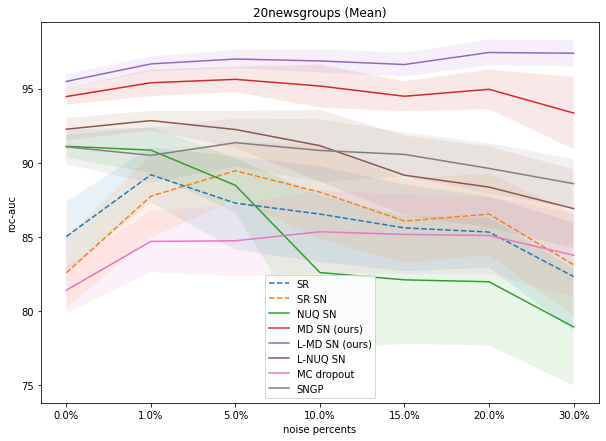

In [18]:
ue_algorithms = ['max_prob', 'nuq_epistemic', 'mahalanobis_distance', 'ddu', 
                 'l_mahalanobis_distance', 'l_nuq_epistemic', 'sampled_max_prob', 'std']

datasets = ['20newsgroups (Mean)']
metric = 'roc-auc'
xvals = [0.0, 0.01, 0.05, 0.1, 0.15, 0.2, 0.3]

table_res = pd.concat([table_all, baselines_all])

for dataset in datasets:
    plot_method_curves(table_res, ue_algorithms, dataset, metric, xvals, xname='noise_perc_')

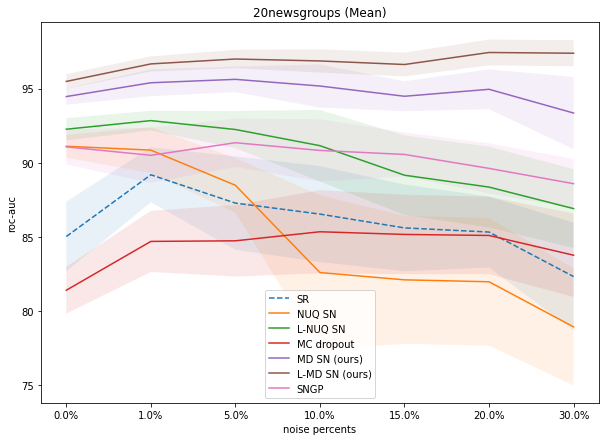

In [19]:
ue_algorithms = ['max_prob|no_sn', 'nuq_epistemic|sn', 'l_nuq_epistemic|sn', 'sampled_max_prob|no_sn',
                 'mahalanobis_distance|sn', 'l_mahalanobis_distance|sn', 'ddu|sn', 'std|sn']


datasets = ['20newsgroups (Mean)']
metric = 'roc-auc'
xvals = [0.0, 0.01, 0.05, 0.1, 0.15, 0.2, 0.3]

table_res = pd.concat([table_all, baselines_all])

save_dir = '../../workdir/curves'
for dataset in datasets:
    plot_method_curves(table_res, ue_algorithms, dataset, metric, xvals, xname='noise_perc_', save_dir=save_dir)

## Full Results

In [20]:
import sys
sys.path.insert(0,'..')

import yaml
import os
from yaml import Loader as Loader
from pathlib import Path
import pandas as pd
import numpy as np
import json
from sklearn.metrics import roc_auc_score

from analyze_results import (
    extract_result,
    aggregate_runs,
    from_model_outputs_calc_rcc_auc,
    format_results2,
    improvement_over_baseline,
    from_model_outputs_calc_pr_auc,
    from_model_outputs_calc_rpp,
    from_model_outputs_calc_roc_auc,
    from_model_outputs_calc_arc_auc,
    from_model_outputs_calc_f1_score,
    from_model_outputs_calc_recall,
    from_model_outputs_calc_precision
)

from utils.utils_wandb import init_wandb, wandb
from ue4nlp.ue_scores import *


def choose_metric(metric_type):
    if metric_type  == "rejection-curve-auc":
        return metric_type
    elif metric_type  == "roc-auc":
        return metric_type
    elif metric_type == "rcc-auc":
        return from_model_outputs_calc_rcc_auc
    elif metric_type == "rpp":
        return from_model_outputs_calc_rpp
    elif metric_type == "pr-auc":
        return from_model_outputs_calc_pr_auc
    elif metric_type == "f1-score":
        return from_model_outputs_calc_f1_score
    elif metric_type == "recall":
        return from_model_outputs_calc_recall
    elif metric_type == "precision":
        return from_model_outputs_calc_precision
    else:
        raise ValueError("Wrong metric type!")

In [21]:
def get_one_table(runs_dir, metric_types=["rejection-curve-auc", "roc-auc", "pr-auc"], baseline=None, methods=None):
    default_methods = {
        "bald": bald,
        "sampled_max_prob": sampled_max_prob,
        "variance": probability_variance,
    }
    
    if methods is None:
        methods = default_methods

    table = []
    for metric_type in metric_types:
        metric = choose_metric(metric_type=metric_type)

        agg_res = aggregate_runs(
            runs_dir, methods=methods, metric=metric, oos=True
        )
        #if 'sngp' in runs_dir:
        #    x = agg_res.max_prob.values
        #    agg_res = agg_res[x > (x.mean() - x.std())]
            
        if agg_res.empty:
            print("Broken\n")
            continue

        if metric_type == "rcc-auc":
            final_score = format_results2(agg_res, percents=False)
        elif metric_type == "rpp":
            final_score = format_results2(agg_res, percents=True)
        elif metric_type == "accuracy":
            final_score = format_results2(agg_res, percents=True)
        else:
            final_score = improvement_over_baseline(agg_res, baseline_col="max_prob", baseline=baseline, metric=metric_type, percents=True, subtract=False)
        table.append(final_score)
    res_table = pd.concat(table, axis=1)
    res_table.columns = metric_types
    # fix for rcc-auc and rpp
    if 'baseline (max_prob)' not in res_table.index:
        res_table.loc['baseline (max_prob)'] = 0
    try:
        res_table = res_table.drop(['max_prob', 'count'])
    except:
        res_table = res_table.drop(['count'])
    return res_table


def collect_tables(run_dirs, names, metric_types=["rejection-curve-auc", "roc-auc", "rcc-auc", "pr-auc", "rpp"], baseline=None, methods=None):
    all_tables = []
    for run_dir, name in zip(run_dirs, names):
        buf_table = get_one_table(run_dir, metric_types, baseline, methods)
        #print(buf_table)
        # add name to index
        indices = [(name, ind) for ind in list(buf_table.index)]
        baseline_name = 'baseline|'+'|'.join(name.split('|')[1:])
        buf_table.loc[baseline_name] = buf_table.loc['baseline (max_prob)']
        # add reindex
        indices = indices + [(baseline_name, 'max_prob')]
        
        index = pd.MultiIndex.from_tuples(indices, names=['Method', 'UE Score'])
        buf_table.index = index
        buf_table.drop((name, 'baseline (max_prob)'), inplace=True)
        # add buf_table to final_table
        all_tables.append(buf_table)
    return pd.concat(all_tables)


def collect_datasets(runs_dirs, names, dataset_names, metric_types=["rejection-curve-auc", "roc-auc", "rcc-auc", "pr-auc", "rpp"], baselines={}, methods=None):
    all_tables = []
    for run_dir, dataset_name in zip(runs_dirs, dataset_names):
        #try:
        dataset_table = collect_tables(run_dir, names, metric_types, baselines.get(dataset_name, None), methods=methods)
        columns = pd.MultiIndex.from_tuples([(dataset_name, ind) for ind in list(dataset_table.columns)])
        dataset_table.columns = columns
        all_tables.append(dataset_table)
        #except:
        #    print(f'empty dir {run_dir}')
    return pd.concat(all_tables, axis=1)

In [22]:
def preproc_regs(x):
    reg = x.split('|')[1]
    if reg == 'reg':
        return 'CER'
    elif reg == 'raw':
        return '-'
    else:
        return reg
    
def preproc_method(x):
    method = x.split('|')[0]
    sn = x.split('|')[2]
    if method == 'mahalanobis' and not 'no_sn' in sn:
        return 'MD SN (ours)'
    elif method == 'mahalanobis':
        return 'MD'
    elif method == 'l_mahalanobis' and not 'no_sn' in sn:
        return 'L-MD SN (ours)'
    elif method == 'l_mahalanobis':
        return 'L-MD'
    elif method == 'mc_mahalanobis' and not 'no_sn' in sn:
        return 'SMD SN (ours)'
    elif method == 'mc_mahalanobis':
        return 'SMD'
    elif method == 'nuq' and not 'no_sn' in sn:
        return 'NUQ SN'
    elif method == 'nuq':
        return 'NUQ'
    elif method == 'l_nuq' and not 'no_sn' in sn:
        return 'L-NUQ SN'
    elif method == 'l_nuq':
        return 'L-NUQ'
    elif method == 'sngp':
        return 'SNGP'
    
    elif method == 'decomposing_md' and not 'no_sn' in sn:
        return 'Decomposing SN'
    elif method == 'decomposing_md':
        return 'Decomposing'
    
    elif method == 'nuq_best1' and not 'no_sn' in sn:
        return 'Best1 NUQ SN'
    elif method == 'nuq_best1':
        return 'Best1 NUQ'
    
    elif method == 'ddu' and not 'no_sn' in sn:
        return 'DDU SN'
    elif method == 'ddu':
        return 'DDU'
    
    elif method == 'ddu' and not 'no_sn' in sn:
        return 'DDU SN'
    elif method == 'ddu':
        return 'DDU'
    
    elif method == 'ddu_maha' and not 'no_sn' in sn:
        return 'DDU Maha SN'
    elif method == 'ddu_maha':
        return 'DDU Maha'
    
    elif 'ddpp_dpp' in method:
        return 'DDPP (+DPP) (ours)'
    elif 'ddpp_ood' in method:
        return 'DDPP (+OOD) (ours)'
    elif 'mc' in method and sn == 'sn':
        return 'MC dropout SN'
    elif 'mc' in method:
        return 'MC dropout'
    elif 'Deep' in method:
        return 'Deep Ensemble'
    elif 'baseline' in method and sn == 'no_sn':
        return 'SR (baseline)'
    elif 'baseline' in x and sn == 'sn':
        return 'SR SN'
    return 'SR'

def preproc_ue(x):
    if x == 'bald':
        return 'BALD'
    elif 'sampled_mahalanobis_distance' in x:
        return 'SMD'
    elif 'relative_mahalanobis_distance' in x:
        return 'rel_MD'
    elif 'marginal_mahalanobis_distance' in x:
        return 'marg_MD'
    elif 'mahalanobis_distance' in x:
        return 'MD'
    elif 'sampled_max_prob' in x:
        return 'SMP'
    elif 'variance' in x:
        return 'PV'
    elif 'aleatoric' in x:
        return 'aleatoric'
    elif 'epistemic' in x:
        return 'epistemic'
    elif 'total' in x:
        return 'total'
    elif x == 'disc_md':
        return 'Disc MD'
    elif x == 'nondisc_md':
        return 'Nondisc MD'
    elif x == 'disc+nondisc_md':
        return 'Disc+Nondisc MD'
    elif x == 'sngp':
        return 'std'
    return 'MP'

In [23]:
def bold_max(table):
    attr = 'font-weight: bold'
    data = table[table.columns[3:]].apply(lambda x: x.str.split('±').str[0].astype(float))
    is_max = data == data.max()
    info_col = table[table.columns[:3]]
    for col in info_col.columns:
        info_col[col] = ''
    vals = pd.DataFrame(np.where(is_max, attr, ''),
                        index=data.index, columns=data.columns)
    return pd.concat([info_col, vals], axis=1)

def highlight_nmax(s):
    try:
        s_vals = s.str.split('±').str[0].astype(float)
        is_large = s_vals.nlargest(3).values
        return ['background-color: yellow' if v in is_large else '' for v in s_vals]
    except:
        return ['']*len(s)

In [24]:
metric_types=["roc-auc", 'pr-auc', 'f1-score', 'precision', 'recall']


def choose_agg_func(method):
    agg_methods = {
        "bald": bald,
        "sampled_max_prob": sampled_max_prob,
        "variance": probability_variance,
    }
    if method=='nuq' or method=='nuq_best' or method=='nuq_best1':
        nuq_aleatoric = lambda x: np.squeeze(x[0], axis=-1)
        nuq_epistemic = lambda x: np.squeeze(x[1], axis=-1)
        nuq_total = lambda x: np.squeeze(x[2], axis=-1)
        agg_methods = {
            "nuq_aleatoric": nuq_aleatoric,
            "nuq_epistemic": nuq_epistemic,
            "nuq_total": nuq_total,
        }
    elif method=='decomposing_md':
        disc_md = lambda x: np.squeeze(x[0], axis=-1)
        nondisc_md = lambda x: np.squeeze(x[1], axis=-1)
        sum_md = lambda x: np.squeeze(x[2], axis=-1)
        agg_methods = {"disc_md": disc_md, 
                       'nondisc_md': nondisc_md,
                       'disc+nondisc_md': sum_md}
    elif method=='mahalanobis':
        maha_dist = lambda x: np.squeeze(x[:, 0], axis=-1)
        rel_maha_dist = lambda x: np.squeeze(x[1], axis=-1)
        marg_maha_dist = lambda x: np.squeeze(x[2], axis=-1)
        agg_methods = {"mahalanobis_distance": maha_dist,
                       #"relative_mahalanobis_distance": rel_maha_dist,
                       #"marginal_mahalanobis_distance": marg_maha_dist
                      }
    elif method=='sngp':
        maha_dist = lambda x: np.squeeze(x[:, 0], axis=-1)
        #rel_maha_dist = lambda x: np.squeeze(x[1], axis=-1)
        #marg_maha_dist = lambda x: np.squeeze(x[2], axis=-1)
        agg_methods = {"std": maha_dist,
                       #"relative_mahalanobis_distance": rel_maha_dist,
                       #"marginal_mahalanobis_distance": marg_maha_dist
                      }
    elif method=='l_nuq':
        nuq_aleatoric = lambda x: np.squeeze(x[0], axis=-1)
        nuq_epistemic = lambda x: np.squeeze(x[1], axis=-1)
        nuq_total = lambda x: np.squeeze(x[2], axis=-1)
        agg_methods = {
            "l_nuq_aleatoric": nuq_aleatoric,
            "l_nuq_epistemic": nuq_epistemic,
            "l_nuq_total": nuq_total,
        }       
    elif method=='ddu' or method=='ddu_maha':
        ddu = lambda x: -np.squeeze(x[:, 0], axis=-1)
        agg_methods = {"ddu": ddu}
    elif method=='l_mahalanobis':
        ddu = lambda x: np.squeeze(x[:, 0], axis=-1)
        agg_methods = {"l_mahalanobis_distance": ddu}
    elif method=='sngp':
        sngp = lambda x: np.squeeze(x[:, 0], axis=-1)
        agg_methods = {"sngp": sngp}
    elif method=='mc_mahalanobis':
        sm_maha_dist = lambda x: np.squeeze(x[:, 1:], axis=-1).max(1)
        agg_methods = {"sampled_mahalanobis_distance": sm_maha_dist}
    return agg_methods


methods = ['l_mahalanobis', 'mahalanobis', 'nuq', 'l_nuq', 'mc', 'sngp']
regs = ['raw']
spectralnorm = ['no_sn', 'sn']
dataset_names = ['IMDB', 'TREC', 'WMT16', 'Amazon', 'MNLI', '20newsgroups', 'RTE']
dataset_fnames = ['imdb', 'trec', 'wmt16', 'amazon', 'mnli', '20newsgroups', 'rte']
subsample_percs = [0.1]
names = []
tables = []
baselines = []
for method in methods:
    for reg in regs:
        for sn in spectralnorm:
            for subsample_perc in subsample_percs:
                if method == 'sngp' and sn != 'sn':
                    continue
                if method == 'mc' and sn == 'sn':
                    continue
                run_dirs = []
                name_sn = ''
                names = [f'{method}|{reg}|{sn}|subsample_perc_{subsample_perc}']
                for name in dataset_fnames:
                    if method == 'sngp':
                        model_series_dir = f'../../workdir/run_tasks_for_model_series/electra_{reg}_sngp/sst2/subsample_perc_{subsample_perc}/{name}/{method}'
                    else:
                        model_series_dir = f'../../workdir/run_tasks_for_model_series/electra_{reg}_{sn}/sst2/subsample_perc_{subsample_perc}/{name}/{method}'
                    print(model_series_dir)
                    run_dirs.append([model_series_dir])
                agg_func = choose_agg_func(method)
                try:
                    res_df = collect_datasets(run_dirs, names, dataset_names, metric_types=metric_types, baselines={}, methods=agg_func)
                    baselines.append(res_df.iloc[-1:])
                    tables.append(res_df.iloc[:-1])
                except:
                    print('pass')
                    pass

../../workdir/run_tasks_for_model_series/electra_raw_no_sn/sst2/subsample_perc_0.1/imdb/l_mahalanobis
../../workdir/run_tasks_for_model_series/electra_raw_no_sn/sst2/subsample_perc_0.1/trec/l_mahalanobis
../../workdir/run_tasks_for_model_series/electra_raw_no_sn/sst2/subsample_perc_0.1/wmt16/l_mahalanobis
../../workdir/run_tasks_for_model_series/electra_raw_no_sn/sst2/subsample_perc_0.1/amazon/l_mahalanobis
../../workdir/run_tasks_for_model_series/electra_raw_no_sn/sst2/subsample_perc_0.1/mnli/l_mahalanobis
../../workdir/run_tasks_for_model_series/electra_raw_no_sn/sst2/subsample_perc_0.1/20newsgroups/l_mahalanobis
../../workdir/run_tasks_for_model_series/electra_raw_no_sn/sst2/subsample_perc_0.1/rte/l_mahalanobis
pass
../../workdir/run_tasks_for_model_series/electra_raw_sn/sst2/subsample_perc_0.1/imdb/l_mahalanobis
../../workdir/run_tasks_for_model_series/electra_raw_sn/sst2/subsample_perc_0.1/trec/l_mahalanobis
../../workdir/run_tasks_for_model_series/electra_raw_sn/sst2/subsample_pe

In [25]:
table_all = pd.concat([pd.concat([t[:-1] for t in tables]), pd.concat(baselines[:2])]).reset_index()

In [26]:
table_all['Reg. Type'] = table_all.Method.apply(lambda x: preproc_regs(x))
table_all['Method'] = table_all.Method.apply(lambda x: preproc_method(x))
table_all['UE Score'] = table_all['UE Score'].apply(lambda x: preproc_ue(x))
table_all = table_all[list(table_all.columns[:1]) + list(table_all.columns[-1:]) + list(table_all.columns[1:-1])].reset_index(drop=True)

In [27]:
roc_auc_mean = table_all[table_all.columns[3::5]].apply(lambda x: x.str.split('±').str[0].astype(float)).mean(axis=1)
roc_auc_std = table_all[table_all.columns[3::5]].apply(lambda x: x.str.split('±').str[1].astype(float)).mean(axis=1)

f1_mean = table_all[table_all.columns[5::5]].apply(lambda x: x.str.split('±').str[0].astype(float)).mean(axis=1)
f1_std = table_all[table_all.columns[5::5]].apply(lambda x: x.str.split('±').str[1].astype(float)).mean(axis=1)

pr_auc_mean = table_all[table_all.columns[4::5]].apply(lambda x: x.str.split('±').str[0].astype(float)).mean(axis=1)
pr_auc_std = table_all[table_all.columns[4::5]].apply(lambda x: x.str.split('±').str[1].astype(float)).mean(axis=1)

pr_mean = table_all[table_all.columns[6::5]].apply(lambda x: x.str.split('±').str[0].astype(float)).mean(axis=1)
pr_std = table_all[table_all.columns[6::5]].apply(lambda x: x.str.split('±').str[1].astype(float)).mean(axis=1)

rec_auc_mean = table_all[table_all.columns[7::5]].apply(lambda x: x.str.split('±').str[0].astype(float)).mean(axis=1)
rec_auc_std = table_all[table_all.columns[7::5]].apply(lambda x: x.str.split('±').str[1].astype(float)).mean(axis=1)

In [28]:
table_all[('Mean',  'pr-auc')] = pr_auc_mean.round(2).astype(str)+'±'+pr_auc_std.round(2).astype(str)
table_all[('Mean',  'f1-score')] = f1_mean.round(2).astype(str)+'±'+f1_std.round(2).astype(str)
table_all[('Mean',  'precision')] = pr_mean.round(2).astype(str)+'±'+pr_std.round(2).astype(str)
table_all[('Mean',  'recall')] = rec_auc_mean.round(2).astype(str)+'±'+rec_auc_std.round(2).astype(str)
table_all[('Mean',  'roc-auc')] = roc_auc_mean.round(2).astype(str)+'±'+roc_auc_std.round(2).astype(str)

In [29]:
mean_res = table_all[list(table_all.columns[:3]) + list(table_all.columns[-5:])]
mean_res.style.apply(highlight_nmax).apply(bold_max, axis=None)

/home/user/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [30]:
def prepare_latex_table(table):
    latex_table = table.to_latex(bold_rows=False, index=False)
    latex_table = latex_table.replace('\\$\\textbackslash pm\\$', '$\pm$')
    latex_table = latex_table.replace('variance', 'PV')
    latex_table = latex_table.replace('var\_ratio', 'VR')
    latex_table = latex_table.replace('sampled\_entropy', 'SE')
    latex_table = latex_table.replace('sampled\_max\_prob', 'SMP')
    latex_table = latex_table.replace('mahalanobis\_distance', 'MD')
    latex_table = latex_table.replace('max\_prob', 'MP')
    latex_table = latex_table.replace('bald', 'BALD')
    latex_table = latex_table.replace('mixup', 'DS')
    latex_table = latex_table.replace('stds', 'STD')
    latex_table = latex_table.replace('\\textbackslash ', '\\')
    latex_table = latex_table.replace('\\{', '{')
    latex_table = latex_table.replace('\\}', '}')
    
    header = """\\begin{table*}[!ht]
        \\resizebox{\\textwidth}{!}{
        \begin{tabular}{l|l||c|c|c|c|c}
        \toprule
        \multirow{2}{*}{\textbf{Method}} & 
        \multirow{2}{*}{\textbf{\multirowcell{UE\\Score}}} & \multicolumn{5}{c}{\textbf{Mean Score}}\\
              \cline{3-7}
                 & &  \textbf{PR-AUC $\downarrow$} &      \textbf{F1-score $\downarrow$} &  \textbf{Precision $\downarrow$} &      \textbf{Recall $\downarrow$} &   \textbf{ROC-AUC $\downarrow$}\\
        \\midrule \\hline """
    latex_table = header + latex_table.split('midrule')[1]
    bottom = """
    \\bottomrule
    \\end{tabular}
    }
    \\caption{\\label{tab:electra_ood_mean}Comparison of the best results for all methods (ELECTRA model) for OOD detection. The best results overall are highlighted with the bold font, the top-3 best results are underlined.}
    \\end{table*}"""
    latex_table = latex_table.split('\\bottomrule')[0] + bottom
    return latex_table

In [31]:
def highlight_nmax_latex(s):
    try:
        s_vals = s.str.split('±').str[0].astype(float)
        is_top3 = s_vals.nlargest(3).values
        is_top1 = s_vals.nlargest(1).values
        s_vals_latex = []
        for v, v_full in zip(s_vals, s):
            if v in is_top1:
                s_vals_latex.append('\\textbf{'+v_full+'}')
            elif v in is_top3:
                s_vals_latex.append('\\underline{'+v_full+'}')
            else:
                s_vals_latex.append(v)
        return s_vals_latex
    except:
        return s

In [32]:
print(prepare_latex_table(mean_res.apply(highlight_nmax_latex)))

\begin{table*}[!ht]
        \resizebox{\textwidth}{!}{
       egin{tabular}{l|l||c|c|c|c|c}
        	oprule
        \multirow{2}{*}{	extbf{Method}} & 
        \multirow{2}{*}{	extbf{\multirowcell{UE\Score}}} & \multicolumn{5}{c}{	extbf{Mean Score}}\
              \cline{3-7}
                 & &  	extbf{PR-AUC $\downarrow$} &      	extbf{F1-score $\downarrow$} &  	extbf{Precision $\downarrow$} &      	extbf{Recall $\downarrow$} &   	extbf{ROC-AUC $\downarrow$}\
        \midrule \hline 
L-MD SN (ours) &         - &        MD & \underline{93.02±1.44} &    \textbf{92.85±0.75} &   \textbf{89.84±1.18} &    \textbf{96.49±0.63} &    \textbf{92.98±0.99} \\
            MD &         - &        MD &                  90.54 & \underline{91.24±0.75} &                 87.13 & \underline{96.48±0.77} &                  87.02 \\
  MD SN (ours) &         - &        MD &                  91.14 &                  90.98 &                  87.2 &                  95.64 &                  85.33 \\
           

In [33]:
metric_types=["roc-auc", 'pr-auc', 'f1-score', 'precision', 'recall']


def choose_agg_func(method):
    agg_methods = {
        "bald": bald,
        "sampled_max_prob": sampled_max_prob,
        "variance": probability_variance,
    }
    if method=='nuq' or method=='nuq_best' or method=='nuq_best1':
        nuq_aleatoric = lambda x: np.squeeze(x[0], axis=-1)
        nuq_epistemic = lambda x: np.squeeze(x[1], axis=-1)
        nuq_total = lambda x: np.squeeze(x[2], axis=-1)
        agg_methods = {
            "nuq_aleatoric": nuq_aleatoric,
            "nuq_epistemic": nuq_epistemic,
            "nuq_total": nuq_total,
        }
    elif method=='decomposing_md':
        disc_md = lambda x: np.squeeze(x[0], axis=-1)
        nondisc_md = lambda x: np.squeeze(x[1], axis=-1)
        sum_md = lambda x: np.squeeze(x[2], axis=-1)
        agg_methods = {"disc_md": disc_md, 
                       'nondisc_md': nondisc_md,
                       'disc+nondisc_md': sum_md}
    elif method=='mahalanobis':
        maha_dist = lambda x: np.squeeze(x[:, 0], axis=-1)
        rel_maha_dist = lambda x: np.squeeze(x[1], axis=-1)
        marg_maha_dist = lambda x: np.squeeze(x[2], axis=-1)
        agg_methods = {"mahalanobis_distance": maha_dist,
                       #"relative_mahalanobis_distance": rel_maha_dist,
                       #"marginal_mahalanobis_distance": marg_maha_dist
                      }
    elif method=='sngp':
        maha_dist = lambda x: np.squeeze(x[:, 0], axis=-1)
        #rel_maha_dist = lambda x: np.squeeze(x[1], axis=-1)
        #marg_maha_dist = lambda x: np.squeeze(x[2], axis=-1)
        agg_methods = {"std": maha_dist,
                       #"relative_mahalanobis_distance": rel_maha_dist,
                       #"marginal_mahalanobis_distance": marg_maha_dist
                      }
    elif method=='l_nuq':
        nuq_aleatoric = lambda x: np.squeeze(x[0], axis=-1)
        nuq_epistemic = lambda x: np.squeeze(x[1], axis=-1)
        nuq_total = lambda x: np.squeeze(x[2], axis=-1)
        agg_methods = {
            "l_nuq_aleatoric": nuq_aleatoric,
            "l_nuq_epistemic": nuq_epistemic,
            "l_nuq_total": nuq_total,
        }       
    elif method=='ddu' or method=='ddu_maha':
        ddu = lambda x: -np.squeeze(x[:, 0], axis=-1)
        agg_methods = {"ddu": ddu}
    elif method=='l_mahalanobis':
        ddu = lambda x: np.squeeze(x[:, 0], axis=-1)
        agg_methods = {"l_mahalanobis_distance": ddu}
    elif method=='sngp':
        sngp = lambda x: np.squeeze(x[:, 0], axis=-1)
        agg_methods = {"sngp": sngp}
    elif method=='mc_mahalanobis':
        sm_maha_dist = lambda x: np.squeeze(x[:, 1:], axis=-1).max(1)
        agg_methods = {"sampled_mahalanobis_distance": sm_maha_dist}
    return agg_methods


methods = ['l_mahalanobis', 'mahalanobis', 'nuq', 'l_nuq', 'mc', 'sngp']
regs = ['raw']
spectralnorm = ['no_sn', 'sn']
dataset_names = ['IMDB', 'TREC', 'WMT16', 'Amazon', 'MNLI', 'SST-2', 'RTE']
dataset_fnames = ['imdb', 'trec', 'wmt16', 'amazon', 'mnli', 'sst2', 'rte']
subsample_percs = [0.0]
names = []
tables = []
baselines = []
for method in methods:
    for reg in regs:
        for sn in spectralnorm:
            for subsample_perc in subsample_percs:
                if method == 'sngp' and sn != 'sn':
                    continue
                if method == 'mc' and sn == 'sn':
                    continue
                run_dirs = []
                name_sn = ''
                names = [f'{method}|{reg}|{sn}|subsample_perc_{subsample_perc}']
                for name in dataset_fnames:
                    if method == 'sngp':
                        model_series_dir = f'../../workdir/run_tasks_for_model_series/electra_{reg}_sngp/20newsgroups/subsample_perc_{subsample_perc}/{name}/{method}'
                    else:
                        model_series_dir = f'../../workdir/run_tasks_for_model_series/electra_{reg}_{sn}/20newsgroups/subsample_perc_{subsample_perc}/{name}/{method}'
                    print(model_series_dir)
                    run_dirs.append([model_series_dir])
                agg_func = choose_agg_func(method)
                try:
                    res_df = collect_datasets(run_dirs, names, dataset_names, metric_types=metric_types, baselines={}, methods=agg_func)
                    baselines.append(res_df.iloc[-1:])
                    tables.append(res_df.iloc[:-1])
                except:
                    print('pass')
                    pass

../../workdir/run_tasks_for_model_series/electra_raw_no_sn/20newsgroups/subsample_perc_0.0/imdb/l_mahalanobis
../../workdir/run_tasks_for_model_series/electra_raw_no_sn/20newsgroups/subsample_perc_0.0/trec/l_mahalanobis
../../workdir/run_tasks_for_model_series/electra_raw_no_sn/20newsgroups/subsample_perc_0.0/wmt16/l_mahalanobis
../../workdir/run_tasks_for_model_series/electra_raw_no_sn/20newsgroups/subsample_perc_0.0/amazon/l_mahalanobis
../../workdir/run_tasks_for_model_series/electra_raw_no_sn/20newsgroups/subsample_perc_0.0/mnli/l_mahalanobis
../../workdir/run_tasks_for_model_series/electra_raw_no_sn/20newsgroups/subsample_perc_0.0/sst2/l_mahalanobis
../../workdir/run_tasks_for_model_series/electra_raw_no_sn/20newsgroups/subsample_perc_0.0/rte/l_mahalanobis
pass
../../workdir/run_tasks_for_model_series/electra_raw_sn/20newsgroups/subsample_perc_0.0/imdb/l_mahalanobis
../../workdir/run_tasks_for_model_series/electra_raw_sn/20newsgroups/subsample_perc_0.0/trec/l_mahalanobis
../../wor

In [34]:
table_all = pd.concat([pd.concat([t[:-1] for t in tables]), pd.concat(baselines[:2])]).reset_index()

In [35]:
table_all['Reg. Type'] = table_all.Method.apply(lambda x: preproc_regs(x))
table_all['Method'] = table_all.Method.apply(lambda x: preproc_method(x))
table_all['UE Score'] = table_all['UE Score'].apply(lambda x: preproc_ue(x))
table_all = table_all[list(table_all.columns[:1]) + list(table_all.columns[-1:]) + list(table_all.columns[1:-1])].reset_index(drop=True)

In [36]:
roc_auc_mean = table_all[table_all.columns[3::5]].apply(lambda x: x.str.split('±').str[0].astype(float)).mean(axis=1)
roc_auc_std = table_all[table_all.columns[3::5]].apply(lambda x: x.str.split('±').str[1].astype(float)).mean(axis=1)

f1_mean = table_all[table_all.columns[5::5]].apply(lambda x: x.str.split('±').str[0].astype(float)).mean(axis=1)
f1_std = table_all[table_all.columns[5::5]].apply(lambda x: x.str.split('±').str[1].astype(float)).mean(axis=1)

pr_auc_mean = table_all[table_all.columns[4::5]].apply(lambda x: x.str.split('±').str[0].astype(float)).mean(axis=1)
pr_auc_std = table_all[table_all.columns[4::5]].apply(lambda x: x.str.split('±').str[1].astype(float)).mean(axis=1)

pr_mean = table_all[table_all.columns[6::5]].apply(lambda x: x.str.split('±').str[0].astype(float)).mean(axis=1)
pr_std = table_all[table_all.columns[6::5]].apply(lambda x: x.str.split('±').str[1].astype(float)).mean(axis=1)

rec_auc_mean = table_all[table_all.columns[7::5]].apply(lambda x: x.str.split('±').str[0].astype(float)).mean(axis=1)
rec_auc_std = table_all[table_all.columns[7::5]].apply(lambda x: x.str.split('±').str[1].astype(float)).mean(axis=1)

In [37]:
table_all[('Mean',  'pr-auc')] = pr_auc_mean.round(2).astype(str)+'±'+pr_auc_std.round(2).astype(str)
table_all[('Mean',  'f1-score')] = f1_mean.round(2).astype(str)+'±'+f1_std.round(2).astype(str)
table_all[('Mean',  'precision')] = pr_mean.round(2).astype(str)+'±'+pr_std.round(2).astype(str)
table_all[('Mean',  'recall')] = rec_auc_mean.round(2).astype(str)+'±'+rec_auc_std.round(2).astype(str)
table_all[('Mean',  'roc-auc')] = roc_auc_mean.round(2).astype(str)+'±'+roc_auc_std.round(2).astype(str)

In [38]:
mean_res = table_all[list(table_all.columns[:3]) + list(table_all.columns[-5:])]
mean_res.style.apply(highlight_nmax).apply(bold_max, axis=None)

/home/user/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [39]:
metric_types=["roc-auc", 'pr-auc', 'f1-score', 'precision', 'recall']


methods = ['l_mahalanobis', 'mahalanobis', 'ddu', 'nuq', 'l_nuq', 'mc', 'sngp']
regs = ['raw']
spectralnorm = ['sn', 'no_sn']
dataset_names = ['CLINC', 'ROSTD']
dataset_fnames = ['clinc', 'rostd']
subsample_percs = [0.0]
names = []
tables = []
baselines = []
for method in methods:
    for reg in regs:
        for sn in spectralnorm:
            for subsample_perc in subsample_percs:
                if method == 'sngp' and sn != 'sn':
                    continue
                if method == 'mc' and sn == 'sn':
                    continue
                run_dirs = []
                name_sn = ''
                names = [f'{method}|{reg}|{sn}|subsample_perc_{subsample_perc}']
                for name in dataset_fnames:
                    if method == 'sngp':
                        model_series_dir = f'../../workdir/run_tasks_for_model_series/electra_{reg}_sngp/{name}/subsample_perc_{subsample_perc}/{method}'
                    else:
                        model_series_dir = f'../../workdir/run_tasks_for_model_series/electra_{reg}_{sn}/{name}/subsample_perc_{subsample_perc}/{method}'
                    print(model_series_dir)
                    run_dirs.append([model_series_dir])
                agg_func = choose_agg_func(method)
                try:
                    res_df = collect_datasets(run_dirs, names, dataset_names, metric_types=metric_types, baselines={}, methods=agg_func)
                    baselines.append(res_df.iloc[-1:])
                    tables.append(res_df.iloc[:-1])
                except:
                    print('pass')
                    pass

../../workdir/run_tasks_for_model_series/electra_raw_sn/clinc/subsample_perc_0.0/l_mahalanobis
../../workdir/run_tasks_for_model_series/electra_raw_sn/rostd/subsample_perc_0.0/l_mahalanobis
../../workdir/run_tasks_for_model_series/electra_raw_no_sn/clinc/subsample_perc_0.0/l_mahalanobis
../../workdir/run_tasks_for_model_series/electra_raw_no_sn/rostd/subsample_perc_0.0/l_mahalanobis
../../workdir/run_tasks_for_model_series/electra_raw_sn/clinc/subsample_perc_0.0/mahalanobis
../../workdir/run_tasks_for_model_series/electra_raw_sn/rostd/subsample_perc_0.0/mahalanobis
../../workdir/run_tasks_for_model_series/electra_raw_no_sn/clinc/subsample_perc_0.0/mahalanobis
../../workdir/run_tasks_for_model_series/electra_raw_no_sn/rostd/subsample_perc_0.0/mahalanobis
../../workdir/run_tasks_for_model_series/electra_raw_sn/clinc/subsample_perc_0.0/ddu
../../workdir/run_tasks_for_model_series/electra_raw_sn/rostd/subsample_perc_0.0/ddu
pass
../../workdir/run_tasks_for_model_series/electra_raw_no_sn/cl

In [40]:
table_all = pd.concat([pd.concat([t[:-1] for t in tables]), pd.concat(baselines[:2])]).reset_index()

In [41]:
table_all['Reg. Type'] = table_all.Method.apply(lambda x: preproc_regs(x))
table_all['Method'] = table_all.Method.apply(lambda x: preproc_method(x))
table_all['UE Score'] = table_all['UE Score'].apply(lambda x: preproc_ue(x))
table_all = table_all[list(table_all.columns[:1]) + list(table_all.columns[-1:]) + list(table_all.columns[1:-1])].reset_index(drop=True)

In [42]:
table_all.style.apply(highlight_nmax).apply(bold_max, axis=None)

/home/user/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
